In [13]:
# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

rnn = "GRU"

In [14]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm
import argparse

# Import the quadruped model components from your second file
from mlp_quadruped_rnn import MLP, MLPQuadrupedProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State


from scipy.spatial.transform import Rotation as R

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

/home/alinjar/simple_training_warm_start/Quadruped_qp
Using cuda device


In [15]:
class ForceDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, desired_speed, desired_twisting_speed):
        # input
        self.inp = inp
        self.desired_speed = desired_speed
        self.desired_twisting_speed = desired_twisting_speed

    def __len__(self):
        return len(self.inp)    
        
    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        desired_speed = self.desired_speed[idx]
        desired_twisting_speed = self.desired_twisting_speed
        return torch.tensor(inp).float(), torch.tensor(desired_speed).float(), torch.tensor(desired_twisting_speed).float()    


def sample_uniform_variables(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng


In [16]:


# Parameters for Quadruped Model
num_batch = 1
timestep = 0.05  # 50 Hz control frequency
horizon = 10     # prediction horizon steps
num_legs = 4
friction_coeff = 0.2
body_mass = 50.0  # kg

body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

# Desired motion parameters
# desired_speed_x_tensor, rng = sample_uniform_variable(42, -0.5, 0.5, 1, 1)
# desired_speed_x = desired_speed_x_tensor.squeeze().item()
# print("desired_speed_x", desired_speed_x)
desired_body_height = 0.5     # m


In [17]:
##Parameters for MLP model
# Default states
BaseRollPitchYaw = (0.0, 0.0, 0.0)
AngularVelocityBodyFrame = (0.0, 0.0, 0.0)
ComVelocityBodyFrame = (0.0, 0.0, 0.0)
FootContacts = (True, True, True, True)
slope_estimate = (0.0, 0.0, 0.0)
RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

roll, pitch, yaw = BaseRollPitchYaw

# Create rotation object from Euler angles (in radians)
rot = R.from_euler('xyz', [roll, pitch, yaw])

# Convert to rotation matrix
rotation_matrix = rot.as_matrix()  # Shape (3, 3)

# Flatten into a 9-element tuple (row-major order)
RotationBodyWrtWorld = tuple(rotation_matrix.flatten())
#self.RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


"""Setup foot positions and default states for quadruped"""
# Foot positions in body frame
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

FootPositionsInBodyFrame = torch.tensor([
    [ foot_x,  foot_y, foot_z],
    [-foot_x,  foot_y, foot_z],
    [ foot_x, -foot_y, foot_z],
    [-foot_x, -foot_y, foot_z]])

# Define QP matrices for quadruped control (simplified example)
# In practice, these would come from your quadruped dynamics model




# Maximum Iterations
maxiter_projection = 5

nvar = 3*num_legs*horizon

num_total_constraints = 2*nvar


In [18]:
dataset_size = 1*num_batch
desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -0.0, var_max = 0.0, dataset_size=dataset_size, nvar=2)
desired_twisting_speed_batched,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      42, var_min= -0.0, var_max = 0.0, dataset_size=dataset_size, 
                                                                      nvar=1)

desired_speed_batched_val, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -0.1, var_max = 0.1, dataset_size=dataset_size, nvar=2)
desired_twisting_speed_batched_val,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      39, var_min= -0.1, var_max = 0.1, dataset_size=dataset_size,
                                                                      nvar=1)

print("desired_speed_batched.shape", desired_speed_batched.shape)
print("desired_twisting_speed_batched.shape", desired_twisting_speed_batched.shape)

inp = np.hstack((desired_speed_batched, desired_twisting_speed_batched))

inp_val = np.hstack(( desired_speed_batched_val, desired_twisting_speed_batched_val))

# Using PyTorch Dataloader
train_dataset = ForceDataset(inp, desired_speed_batched, desired_twisting_speed_batched)
val_dataset = ForceDataset(inp_val, desired_speed_batched_val, desired_twisting_speed_batched_val)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


desired_speed_batched.shape (1, 2)
desired_twisting_speed_batched.shape (1, 1)


In [19]:
if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##


Training with GRU


In [20]:
# MLP setup
enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints  # xi_samples, lambda_samples, slack_variables

mlp = MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)


In [21]:

# Create the quadruped model
model = MLPQuadrupedProjectionFilter(
    mlp=mlp,
    rnn_context=rnn_context, 
    rnn_init=rnn_init, 
    num_batch=num_batch,
    maxiter_projection=maxiter_projection,
    BaseRollPitchYaw=BaseRollPitchYaw,
    AngularVelocityBodyFrame=AngularVelocityBodyFrame,
    ComVelocityBodyFrame=ComVelocityBodyFrame,
    FootPositionsInBodyFrame=FootPositionsInBodyFrame,
    FootContacts=FootContacts,
    slope_estimate=slope_estimate,
    RotationBodyWrtWorld=RotationBodyWrtWorld, 
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    rnn=rnn).to(device)

print(f"Model type: {type(model)}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


Model type: <class 'mlp_quadruped_rnn.MLPQuadrupedProjectionFilter'>
Number of parameters: 4869192


In [22]:
# Training
epochs = 3000
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=6e-5)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_qp_cost_loss = [], [], [], []
avg_val_loss = []

for epoch in range(epochs):
    
    # Train Loop
    model.train()
    losses_train, primal_losses, fixed_point_losses, qp_cost_losses = [], [], [], []
    
    for (inp, desired_speed_batched, desired_twisting_speed_batched) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        
        desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(None, var_min= -2, var_max = 2, dataset_size=dataset_size, nvar=2)
        desired_twisting_speed_batched, rng_desired_twisting_speed_batched = sample_uniform_variables(None, var_min= -0.5, var_max = 0.5, 
                                                                                                     dataset_size=dataset_size, nvar=1)
        
        
        #print("desired_speed_batched", desired_speed_batched)

        desired_speed_batched = torch.tensor(desired_speed_batched).float()
        desired_twisting_speed_batched = torch.tensor(desired_twisting_speed_batched).float()
        # Input and Output 
        inp = inp.to(device)
        desired_speed_batched = desired_speed_batched.to(device)
        desired_twisting_speed_batched = desired_twisting_speed_batched.to(device)
        
        # Forward pass through quadruped model
        xi_projected, avg_res_fixed_point, avg_res_primal, avg_res_qp_cost, res_primal_history, res_fixed_point_history, _ = model(inp, desired_speed_batched, 
                                                                                                               desired_twisting_speed_batched, rnn)
        
        
        # Compute loss
        primal_loss, fixed_point_loss, qp_cost_loss ,loss = model.mlp_loss(
            avg_res_primal, avg_res_fixed_point, avg_res_qp_cost)

        optimizer.zero_grad()
        loss.backward()
        
        # Optional gradient clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        qp_cost_losses.append(qp_cost_loss.detach().cpu().numpy())
        #projection_losses.append(projection_loss.detach().cpu().numpy())
        
    # Validation every 2 epochs
    if epoch % 2 == 0:
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, desired_speed_batched_val, desired_twisting_speed_batched_val) in tqdm(val_loader, desc="Validation"):
                inp_val = inp_val.to(device)
                desired_speed_batched_val = desired_speed_batched_val.to(device)
                desired_twisting_speed_batched_val = desired_twisting_speed_batched_val.to(device)

                xi_projected, avg_res_fixed_point, avg_res_primal, avg_res_qp_cost, res_primal_history, res_fixed_point_history, _ = model(inp_val, desired_speed_batched_val, 
                                                                                                                       desired_twisting_speed_batched_val,
                                                                                                                       rnn)
                
                _, _, _, val_loss = model.mlp_loss(
                    avg_res_primal, avg_res_fixed_point, avg_res_qp_cost
                )

                val_losses.append(val_loss.detach().cpu().numpy())

    # Print progress every 2 epochs
    if epoch % 2 == 0:    
        print(
            f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.4f}, "
        )

              #f"Projection Loss: {np.average(projection_losses):.4f}")
        
        if len(val_losses) > 0:
            print(f"Validation Loss: {np.average(val_losses):.4f}")

    # Save best model
    os.makedirs("./training_weights", exist_ok=True)
    if loss <= last_loss:
        torch.save(model.state_dict(), f"./training_weights/mlp_learned_quadruped_{rnn}.pth")
        last_loss = loss

    # Store metrics
    avg_train_loss.append(np.average(losses_train))
    avg_primal_loss.append(np.average(primal_losses))
    avg_qp_cost_loss.append(np.average(qp_cost_losses))
    avg_fixed_point_loss.append(np.average(fixed_point_losses))
    
    if len(val_losses) > 0:
        avg_val_loss.append(np.average(val_losses))
    else:
        avg_val_loss.append(avg_val_loss[-1] if avg_val_loss else 0.0)

print("Training completed!")



Validation: 100%|██████████| 1/1 [00:00<00:00, 47.78it/s]


Epoch: 1, Train Loss: 5459.3232, 
Validation Loss: 2245.4583


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.08it/s]

Epoch: 3, Train Loss: 2643.6042, 
Validation Loss: 2102.2700



Validation: 100%|██████████| 1/1 [00:00<00:00, 47.97it/s]


Epoch: 5, Train Loss: 3668.6152, 
Validation Loss: 1826.1604


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.94it/s]


Epoch: 7, Train Loss: 2103.4900, 
Validation Loss: 1119.7257


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 9, Train Loss: 2180.0256, 
Validation Loss: 961.0944


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.14it/s]


Epoch: 11, Train Loss: 1813.8091, 
Validation Loss: 881.4308


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.46it/s]


Epoch: 13, Train Loss: 1855.2965, 
Validation Loss: 812.9836


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.50it/s]


Epoch: 15, Train Loss: 1528.2008, 
Validation Loss: 639.3597


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.73it/s]


Epoch: 17, Train Loss: 1198.0281, 
Validation Loss: 750.1196


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.76it/s]


Epoch: 19, Train Loss: 1679.6132, 
Validation Loss: 720.7338


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.97it/s]


Epoch: 21, Train Loss: 1287.7955, 
Validation Loss: 551.8197


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.60it/s]


Epoch: 23, Train Loss: 1165.1777, 
Validation Loss: 538.1642


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch: 25, Train Loss: 782.8400, 
Validation Loss: 578.4838


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 27, Train Loss: 1166.8545, 
Validation Loss: 616.4482


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.88it/s]


Epoch: 29, Train Loss: 939.2504, 
Validation Loss: 520.8351


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


Epoch: 31, Train Loss: 1038.6487, 
Validation Loss: 486.3979


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.08it/s]


Epoch: 33, Train Loss: 1531.3881, 
Validation Loss: 502.7535


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.36it/s]


Epoch: 35, Train Loss: 774.6836, 
Validation Loss: 413.5937


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.05it/s]


Epoch: 37, Train Loss: 923.5542, 
Validation Loss: 377.5341


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.95it/s]


Epoch: 39, Train Loss: 1501.2733, 
Validation Loss: 339.5046


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch: 41, Train Loss: 715.4791, 
Validation Loss: 327.0769


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.32it/s]


Epoch: 43, Train Loss: 736.8054, 
Validation Loss: 334.0993


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch: 45, Train Loss: 717.0215, 
Validation Loss: 362.5814


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


Epoch: 47, Train Loss: 864.7993, 
Validation Loss: 325.8720


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.45it/s]


Epoch: 49, Train Loss: 602.5876, 
Validation Loss: 229.4303


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


Epoch: 51, Train Loss: 603.8163, 
Validation Loss: 167.5341


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.31it/s]


Epoch: 53, Train Loss: 745.8610, 
Validation Loss: 138.7576


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


Epoch: 55, Train Loss: 801.9678, 
Validation Loss: 159.4540


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 57, Train Loss: 426.5025, 
Validation Loss: 224.9742


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.58it/s]


Epoch: 59, Train Loss: 693.6005, 
Validation Loss: 227.4339


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.55it/s]


Epoch: 61, Train Loss: 539.5622, 
Validation Loss: 269.9857


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.53it/s]


Epoch: 63, Train Loss: 589.3971, 
Validation Loss: 280.0658


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.90it/s]


Epoch: 65, Train Loss: 575.9530, 
Validation Loss: 270.4706


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.50it/s]


Epoch: 67, Train Loss: 606.6110, 
Validation Loss: 240.4079


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.23it/s]


Epoch: 69, Train Loss: 504.4832, 
Validation Loss: 234.1416


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.44it/s]


Epoch: 71, Train Loss: 422.7397, 
Validation Loss: 139.8736


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.61it/s]


Epoch: 73, Train Loss: 470.9000, 
Validation Loss: 149.3396


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.25it/s]


Epoch: 75, Train Loss: 792.0582, 
Validation Loss: 163.6481


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.77it/s]


Epoch: 77, Train Loss: 562.8621, 
Validation Loss: 267.7973


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.57it/s]


Epoch: 79, Train Loss: 543.2538, 
Validation Loss: 322.2516


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.19it/s]


Epoch: 81, Train Loss: 765.7804, 
Validation Loss: 376.9403


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.34it/s]


Epoch: 83, Train Loss: 713.2292, 
Validation Loss: 433.2873


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch: 85, Train Loss: 709.6647, 
Validation Loss: 353.3939


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


Epoch: 87, Train Loss: 573.4243, 
Validation Loss: 257.3467


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.06it/s]


Epoch: 89, Train Loss: 279.7731, 
Validation Loss: 273.4498


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.88it/s]


Epoch: 91, Train Loss: 717.6998, 
Validation Loss: 234.1822


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.43it/s]


Epoch: 93, Train Loss: 661.3535, 
Validation Loss: 138.5302


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.37it/s]


Epoch: 95, Train Loss: 527.3981, 
Validation Loss: 123.7641


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.75it/s]


Epoch: 97, Train Loss: 375.8632, 
Validation Loss: 132.6494


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.77it/s]


Epoch: 99, Train Loss: 396.7196, 
Validation Loss: 160.1845


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.72it/s]


Epoch: 101, Train Loss: 489.2108, 
Validation Loss: 218.0006


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.85it/s]


Epoch: 103, Train Loss: 417.1089, 
Validation Loss: 317.5482


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.64it/s]


Epoch: 105, Train Loss: 614.2603, 
Validation Loss: 224.3979


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.01it/s]


Epoch: 107, Train Loss: 443.3037, 
Validation Loss: 165.4153


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s]


Epoch: 109, Train Loss: 604.2147, 
Validation Loss: 137.5845


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.44it/s]


Epoch: 111, Train Loss: 444.5618, 
Validation Loss: 138.8250


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


Epoch: 113, Train Loss: 404.8619, 
Validation Loss: 162.1860


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Epoch: 115, Train Loss: 365.9286, 
Validation Loss: 220.1525


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.19it/s]


Epoch: 117, Train Loss: 382.1119, 
Validation Loss: 235.8936


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.44it/s]


Epoch: 119, Train Loss: 805.9935, 
Validation Loss: 183.4490


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.37it/s]


Epoch: 121, Train Loss: 437.5284, 
Validation Loss: 215.0937


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.80it/s]


Epoch: 123, Train Loss: 465.1848, 
Validation Loss: 239.4453


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.38it/s]


Epoch: 125, Train Loss: 319.0017, 
Validation Loss: 231.2899


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.18it/s]


Epoch: 127, Train Loss: 234.0493, 
Validation Loss: 189.0008


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


Epoch: 129, Train Loss: 415.7306, 
Validation Loss: 194.9041


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch: 131, Train Loss: 418.1968, 
Validation Loss: 209.6539


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.37it/s]


Epoch: 133, Train Loss: 288.8244, 
Validation Loss: 173.7551


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.20it/s]


Epoch: 135, Train Loss: 311.4956, 
Validation Loss: 132.5477


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.18it/s]


Epoch: 137, Train Loss: 553.0748, 
Validation Loss: 174.5349


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s]


Epoch: 139, Train Loss: 412.6872, 
Validation Loss: 230.2189


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.19it/s]


Epoch: 141, Train Loss: 730.6888, 
Validation Loss: 156.1307


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.05it/s]


Epoch: 143, Train Loss: 377.7531, 
Validation Loss: 117.5685


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.43it/s]


Epoch: 145, Train Loss: 496.8071, 
Validation Loss: 126.7309


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch: 147, Train Loss: 291.6241, 
Validation Loss: 176.5356


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.65it/s]


Epoch: 149, Train Loss: 457.0581, 
Validation Loss: 190.2618


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.09it/s]


Epoch: 151, Train Loss: 241.6736, 
Validation Loss: 155.6470


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.62it/s]


Epoch: 153, Train Loss: 504.6855, 
Validation Loss: 126.9699


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.23it/s]


Epoch: 155, Train Loss: 317.4848, 
Validation Loss: 101.9279


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.61it/s]


Epoch: 157, Train Loss: 218.8932, 
Validation Loss: 132.8179


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.23it/s]


Epoch: 159, Train Loss: 327.6574, 
Validation Loss: 131.4707


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.69it/s]


Epoch: 161, Train Loss: 362.0464, 
Validation Loss: 118.5940


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 163, Train Loss: 391.4223, 
Validation Loss: 120.2748


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


Epoch: 165, Train Loss: 260.5160, 
Validation Loss: 142.3000


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.69it/s]


Epoch: 167, Train Loss: 519.8246, 
Validation Loss: 154.9217


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.03it/s]


Epoch: 169, Train Loss: 391.0475, 
Validation Loss: 175.9959


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.04it/s]


Epoch: 171, Train Loss: 275.7720, 
Validation Loss: 145.4272


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 173, Train Loss: 279.9916, 
Validation Loss: 164.6947


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.20it/s]


Epoch: 175, Train Loss: 346.1180, 
Validation Loss: 200.5143


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.61it/s]


Epoch: 177, Train Loss: 310.1305, 
Validation Loss: 238.9464


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.67it/s]


Epoch: 179, Train Loss: 531.2203, 
Validation Loss: 212.4457


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.39it/s]


Epoch: 181, Train Loss: 213.3515, 
Validation Loss: 137.1836


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.01it/s]


Epoch: 183, Train Loss: 414.9334, 
Validation Loss: 109.4955


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.55it/s]


Epoch: 185, Train Loss: 509.9468, 
Validation Loss: 101.2930


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Epoch: 187, Train Loss: 303.3661, 
Validation Loss: 140.1013


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.89it/s]


Epoch: 189, Train Loss: 323.2187, 
Validation Loss: 157.7119


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.94it/s]


Epoch: 191, Train Loss: 315.4509, 
Validation Loss: 114.7854


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.00it/s]


Epoch: 193, Train Loss: 332.0602, 
Validation Loss: 107.9524


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


Epoch: 195, Train Loss: 270.1429, 
Validation Loss: 142.7383


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.46it/s]


Epoch: 197, Train Loss: 276.5221, 
Validation Loss: 144.6034


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.29it/s]


Epoch: 199, Train Loss: 260.8732, 
Validation Loss: 167.2438


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch: 201, Train Loss: 348.5002, 
Validation Loss: 194.5795


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.80it/s]


Epoch: 203, Train Loss: 196.6253, 
Validation Loss: 133.9305


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


Epoch: 205, Train Loss: 171.1762, 
Validation Loss: 87.9853


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Epoch: 207, Train Loss: 362.1510, 
Validation Loss: 93.5180


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.29it/s]


Epoch: 209, Train Loss: 291.9594, 
Validation Loss: 84.2158


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


Epoch: 211, Train Loss: 306.7408, 
Validation Loss: 70.5357


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.65it/s]


Epoch: 213, Train Loss: 372.3415, 
Validation Loss: 95.1171


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.43it/s]


Epoch: 215, Train Loss: 247.1487, 
Validation Loss: 86.7489


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.02it/s]


Epoch: 217, Train Loss: 238.5564, 
Validation Loss: 102.4062


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]


Epoch: 219, Train Loss: 232.2338, 
Validation Loss: 107.0189


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.55it/s]


Epoch: 221, Train Loss: 378.6810, 
Validation Loss: 66.2292


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.33it/s]


Epoch: 223, Train Loss: 307.4197, 
Validation Loss: 38.4682


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.16it/s]


Epoch: 225, Train Loss: 226.7091, 
Validation Loss: 83.5020


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.66it/s]


Epoch: 227, Train Loss: 362.5615, 
Validation Loss: 83.5258


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.77it/s]


Epoch: 229, Train Loss: 232.9303, 
Validation Loss: 65.5343


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.64it/s]


Epoch: 231, Train Loss: 190.2397, 
Validation Loss: 73.3535


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.52it/s]


Epoch: 233, Train Loss: 174.3282, 
Validation Loss: 98.4143


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.09it/s]


Epoch: 235, Train Loss: 297.8653, 
Validation Loss: 78.1412


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.46it/s]


Epoch: 237, Train Loss: 216.4580, 
Validation Loss: 109.2690


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.13it/s]


Epoch: 239, Train Loss: 298.2515, 
Validation Loss: 103.9616


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.30it/s]


Epoch: 241, Train Loss: 220.6168, 
Validation Loss: 65.3093


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.11it/s]


Epoch: 243, Train Loss: 245.8746, 
Validation Loss: 71.0762


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.54it/s]


Epoch: 245, Train Loss: 277.6042, 
Validation Loss: 72.3051


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch: 247, Train Loss: 292.6723, 
Validation Loss: 93.5737


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 249, Train Loss: 324.1408, 
Validation Loss: 106.4334


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.09it/s]


Epoch: 251, Train Loss: 335.4083, 
Validation Loss: 147.5274


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.02it/s]


Epoch: 253, Train Loss: 241.0263, 
Validation Loss: 184.3740


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.65it/s]


Epoch: 255, Train Loss: 454.2732, 
Validation Loss: 142.6695


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.11it/s]


Epoch: 257, Train Loss: 197.4728, 
Validation Loss: 122.9573


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.07it/s]


Epoch: 259, Train Loss: 333.8965, 
Validation Loss: 214.0177


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


Epoch: 261, Train Loss: 306.8481, 
Validation Loss: 213.7236


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.76it/s]


Epoch: 263, Train Loss: 278.6378, 
Validation Loss: 103.0444


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.97it/s]


Epoch: 265, Train Loss: 301.8369, 
Validation Loss: 99.9467


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.20it/s]


Epoch: 267, Train Loss: 220.8846, 
Validation Loss: 108.9890


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.01it/s]


Epoch: 269, Train Loss: 190.8684, 
Validation Loss: 98.8829


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


Epoch: 271, Train Loss: 196.7636, 
Validation Loss: 115.5697


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.98it/s]


Epoch: 273, Train Loss: 299.4826, 
Validation Loss: 174.6940


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.72it/s]


Epoch: 275, Train Loss: 302.8783, 
Validation Loss: 148.4796


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.05it/s]


Epoch: 277, Train Loss: 242.7177, 
Validation Loss: 103.6167


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.79it/s]


Epoch: 279, Train Loss: 214.4482, 
Validation Loss: 96.7241


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch: 281, Train Loss: 113.5157, 
Validation Loss: 93.5877


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.83it/s]


Epoch: 283, Train Loss: 187.1196, 
Validation Loss: 81.0388


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.07it/s]


Epoch: 285, Train Loss: 262.4746, 
Validation Loss: 97.8296


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.11it/s]


Epoch: 287, Train Loss: 236.8597, 
Validation Loss: 100.3327


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


Epoch: 289, Train Loss: 236.2017, 
Validation Loss: 64.4593


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.18it/s]


Epoch: 291, Train Loss: 179.1210, 
Validation Loss: 69.7456


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.35it/s]


Epoch: 293, Train Loss: 228.1271, 
Validation Loss: 98.8250


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.67it/s]


Epoch: 295, Train Loss: 204.2855, 
Validation Loss: 70.2163


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.07it/s]


Epoch: 297, Train Loss: 174.7940, 
Validation Loss: 52.7380


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.11it/s]


Epoch: 299, Train Loss: 212.8268, 
Validation Loss: 50.5419


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch: 301, Train Loss: 173.1384, 
Validation Loss: 50.7292


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s]


Epoch: 303, Train Loss: 150.0625, 
Validation Loss: 61.1621


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.08it/s]


Epoch: 305, Train Loss: 143.4126, 
Validation Loss: 53.1794


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.01it/s]


Epoch: 307, Train Loss: 294.3652, 
Validation Loss: 55.0120


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.45it/s]


Epoch: 309, Train Loss: 195.4242, 
Validation Loss: 73.6103


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.14it/s]


Epoch: 311, Train Loss: 172.3924, 
Validation Loss: 77.6810


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.97it/s]


Epoch: 313, Train Loss: 324.7290, 
Validation Loss: 69.1576


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


Epoch: 315, Train Loss: 219.9823, 
Validation Loss: 83.4288


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.73it/s]


Epoch: 317, Train Loss: 167.6151, 
Validation Loss: 73.0431


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.59it/s]


Epoch: 319, Train Loss: 168.5087, 
Validation Loss: 44.5049


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.20it/s]


Epoch: 321, Train Loss: 210.4651, 
Validation Loss: 61.9581


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.70it/s]


Epoch: 323, Train Loss: 224.6203, 
Validation Loss: 67.9590


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.68it/s]


Epoch: 325, Train Loss: 222.2957, 
Validation Loss: 53.9363


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.74it/s]


Epoch: 327, Train Loss: 96.8145, 
Validation Loss: 70.2092


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.55it/s]


Epoch: 329, Train Loss: 160.1796, 
Validation Loss: 99.9876


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.67it/s]


Epoch: 331, Train Loss: 99.5439, 
Validation Loss: 99.0774


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


Epoch: 333, Train Loss: 108.1095, 
Validation Loss: 84.1540


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.40it/s]


Epoch: 335, Train Loss: 194.2413, 
Validation Loss: 74.3624


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.12it/s]


Epoch: 337, Train Loss: 162.8452, 
Validation Loss: 63.1749


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.97it/s]


Epoch: 339, Train Loss: 149.3084, 
Validation Loss: 50.0797


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.87it/s]


Epoch: 341, Train Loss: 130.6206, 
Validation Loss: 66.7216


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.83it/s]


Epoch: 343, Train Loss: 162.2255, 
Validation Loss: 68.1733


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.09it/s]


Epoch: 345, Train Loss: 98.5535, 
Validation Loss: 62.7029


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]


Epoch: 347, Train Loss: 151.3857, 
Validation Loss: 78.9196


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.18it/s]


Epoch: 349, Train Loss: 235.8818, 
Validation Loss: 93.9815


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.19it/s]


Epoch: 351, Train Loss: 215.2687, 
Validation Loss: 60.1167


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.05it/s]


Epoch: 353, Train Loss: 108.2232, 
Validation Loss: 37.1094


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.68it/s]


Epoch: 355, Train Loss: 185.9949, 
Validation Loss: 57.2507


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.38it/s]


Epoch: 357, Train Loss: 235.4311, 
Validation Loss: 98.8825


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.99it/s]


Epoch: 359, Train Loss: 220.8095, 
Validation Loss: 83.1818


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch: 361, Train Loss: 314.3282, 
Validation Loss: 74.8439


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Epoch: 363, Train Loss: 238.2017, 
Validation Loss: 84.5901


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.25it/s]


Epoch: 365, Train Loss: 171.3945, 
Validation Loss: 55.3514


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.27it/s]


Epoch: 367, Train Loss: 204.9601, 
Validation Loss: 54.6996


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


Epoch: 369, Train Loss: 125.3610, 
Validation Loss: 69.2360


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.78it/s]


Epoch: 371, Train Loss: 232.2935, 
Validation Loss: 60.1430


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch: 373, Train Loss: 189.4406, 
Validation Loss: 57.7116


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.65it/s]


Epoch: 375, Train Loss: 182.1282, 
Validation Loss: 77.6999


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.71it/s]


Epoch: 377, Train Loss: 246.4229, 
Validation Loss: 87.9935


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


Epoch: 379, Train Loss: 183.7514, 
Validation Loss: 81.6875


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


Epoch: 381, Train Loss: 351.0095, 
Validation Loss: 63.4514


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.02it/s]


Epoch: 383, Train Loss: 115.3610, 
Validation Loss: 62.3693


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.49it/s]


Epoch: 385, Train Loss: 174.8157, 
Validation Loss: 67.4366


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.93it/s]


Epoch: 387, Train Loss: 142.2895, 
Validation Loss: 80.5203


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Epoch: 389, Train Loss: 210.7065, 
Validation Loss: 70.5507


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.81it/s]


Epoch: 391, Train Loss: 188.2624, 
Validation Loss: 50.6620


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.02it/s]


Epoch: 393, Train Loss: 188.2514, 
Validation Loss: 41.2347


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.61it/s]


Epoch: 395, Train Loss: 192.8363, 
Validation Loss: 69.3320


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.62it/s]


Epoch: 397, Train Loss: 258.5797, 
Validation Loss: 93.6358


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.66it/s]


Epoch: 399, Train Loss: 185.9375, 
Validation Loss: 89.7242


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.94it/s]


Epoch: 401, Train Loss: 144.1825, 
Validation Loss: 80.0258


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.92it/s]


Epoch: 403, Train Loss: 268.0204, 
Validation Loss: 91.7221


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.60it/s]


Epoch: 405, Train Loss: 196.1222, 
Validation Loss: 101.6771


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch: 407, Train Loss: 265.1403, 
Validation Loss: 74.2844


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.95it/s]


Epoch: 409, Train Loss: 170.2981, 
Validation Loss: 33.4625


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s]


Epoch: 411, Train Loss: 123.2801, 
Validation Loss: 40.1421


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.98it/s]


Epoch: 413, Train Loss: 150.7723, 
Validation Loss: 69.2689


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.68it/s]


Epoch: 415, Train Loss: 200.6945, 
Validation Loss: 65.6855


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.67it/s]


Epoch: 417, Train Loss: 99.8887, 
Validation Loss: 36.5190


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.90it/s]


Epoch: 419, Train Loss: 63.8538, 
Validation Loss: 32.7226


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.69it/s]


Epoch: 421, Train Loss: 104.2298, 
Validation Loss: 34.8259


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.45it/s]


Epoch: 423, Train Loss: 80.4319, 
Validation Loss: 48.9642


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


Epoch: 425, Train Loss: 165.4527, 
Validation Loss: 38.5858


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.01it/s]


Epoch: 427, Train Loss: 124.6594, 
Validation Loss: 35.1963


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.82it/s]


Epoch: 429, Train Loss: 148.5618, 
Validation Loss: 44.7276


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.65it/s]


Epoch: 431, Train Loss: 164.5332, 
Validation Loss: 54.9290


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.41it/s]


Epoch: 433, Train Loss: 111.4419, 
Validation Loss: 58.3036


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s]


Epoch: 435, Train Loss: 87.7578, 
Validation Loss: 49.6458


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.40it/s]


Epoch: 437, Train Loss: 83.7178, 
Validation Loss: 33.7693


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


Epoch: 439, Train Loss: 136.5283, 
Validation Loss: 33.8428


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.85it/s]


Epoch: 441, Train Loss: 112.2517, 
Validation Loss: 39.1797


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.50it/s]


Epoch: 443, Train Loss: 137.9820, 
Validation Loss: 38.6182


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.74it/s]


Epoch: 445, Train Loss: 151.8613, 
Validation Loss: 40.8162


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.16it/s]


Epoch: 447, Train Loss: 98.3747, 
Validation Loss: 47.1031


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.65it/s]


Epoch: 449, Train Loss: 133.2486, 
Validation Loss: 37.4965


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]


Epoch: 451, Train Loss: 67.9280, 
Validation Loss: 42.7740


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.63it/s]


Epoch: 453, Train Loss: 157.1155, 
Validation Loss: 51.6067


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.41it/s]


Epoch: 455, Train Loss: 166.4962, 
Validation Loss: 48.7579


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.17it/s]


Epoch: 457, Train Loss: 175.4792, 
Validation Loss: 63.8310


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.55it/s]


Epoch: 459, Train Loss: 108.5689, 
Validation Loss: 53.9545


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.19it/s]


Epoch: 461, Train Loss: 138.5712, 
Validation Loss: 50.9232


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.95it/s]


Epoch: 463, Train Loss: 175.2650, 
Validation Loss: 52.8197


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.78it/s]


Epoch: 465, Train Loss: 150.1901, 
Validation Loss: 34.7750


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.48it/s]


Epoch: 467, Train Loss: 153.8039, 
Validation Loss: 36.0715


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


Epoch: 469, Train Loss: 155.6898, 
Validation Loss: 57.5318


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.28it/s]


Epoch: 471, Train Loss: 121.6499, 
Validation Loss: 44.7810


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.29it/s]


Epoch: 473, Train Loss: 147.4280, 
Validation Loss: 52.4609


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Epoch: 475, Train Loss: 205.3200, 
Validation Loss: 68.2678


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.12it/s]


Epoch: 477, Train Loss: 108.7266, 
Validation Loss: 53.7560


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.43it/s]


Epoch: 479, Train Loss: 82.0771, 
Validation Loss: 48.6320


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.16it/s]


Epoch: 481, Train Loss: 270.9518, 
Validation Loss: 45.8820


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 483, Train Loss: 144.1631, 
Validation Loss: 53.6703


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.97it/s]


Epoch: 485, Train Loss: 81.0640, 
Validation Loss: 65.1005


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.55it/s]


Epoch: 487, Train Loss: 123.4342, 
Validation Loss: 57.4084


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.56it/s]


Epoch: 489, Train Loss: 181.0294, 
Validation Loss: 43.7304


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.85it/s]


Epoch: 491, Train Loss: 101.8906, 
Validation Loss: 43.1375


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.33it/s]


Epoch: 493, Train Loss: 98.4618, 
Validation Loss: 59.0628


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.02it/s]


Epoch: 495, Train Loss: 138.0176, 
Validation Loss: 60.0791


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


Epoch: 497, Train Loss: 136.8970, 
Validation Loss: 35.4475


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.81it/s]


Epoch: 499, Train Loss: 106.8856, 
Validation Loss: 38.4498


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.08it/s]


Epoch: 501, Train Loss: 168.1793, 
Validation Loss: 44.4603


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.41it/s]


Epoch: 503, Train Loss: 170.3397, 
Validation Loss: 48.1173


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.14it/s]


Epoch: 505, Train Loss: 77.7895, 
Validation Loss: 49.0308


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.76it/s]


Epoch: 507, Train Loss: 146.1649, 
Validation Loss: 49.0279


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch: 509, Train Loss: 130.3633, 
Validation Loss: 39.6634


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.84it/s]


Epoch: 511, Train Loss: 59.7163, 
Validation Loss: 39.1156


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.95it/s]


Epoch: 513, Train Loss: 117.5981, 
Validation Loss: 53.7152


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.66it/s]


Epoch: 515, Train Loss: 150.0309, 
Validation Loss: 51.1637


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.72it/s]


Epoch: 517, Train Loss: 113.1089, 
Validation Loss: 46.2540


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.26it/s]


Epoch: 519, Train Loss: 98.4421, 
Validation Loss: 32.6815


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.53it/s]


Epoch: 521, Train Loss: 102.7883, 
Validation Loss: 33.0173


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


Epoch: 523, Train Loss: 151.3291, 
Validation Loss: 36.4104


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s]


Epoch: 525, Train Loss: 197.5923, 
Validation Loss: 32.0843


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.33it/s]


Epoch: 527, Train Loss: 61.1832, 
Validation Loss: 36.5244


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.40it/s]


Epoch: 529, Train Loss: 110.6470, 
Validation Loss: 42.5052


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.34it/s]


Epoch: 531, Train Loss: 89.7288, 
Validation Loss: 33.3083


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.20it/s]


Epoch: 533, Train Loss: 77.7435, 
Validation Loss: 30.2636


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.91it/s]


Epoch: 535, Train Loss: 99.1702, 
Validation Loss: 38.3661


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.58it/s]


Epoch: 537, Train Loss: 99.9502, 
Validation Loss: 43.7122


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.84it/s]


Epoch: 539, Train Loss: 106.0021, 
Validation Loss: 29.9406


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.63it/s]


Epoch: 541, Train Loss: 54.4207, 
Validation Loss: 30.1134


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.45it/s]


Epoch: 543, Train Loss: 87.6607, 
Validation Loss: 40.7416


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.68it/s]


Epoch: 545, Train Loss: 144.9518, 
Validation Loss: 38.7251


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.39it/s]


Epoch: 547, Train Loss: 170.8656, 
Validation Loss: 27.3432


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.51it/s]


Epoch: 549, Train Loss: 122.3166, 
Validation Loss: 40.8699


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


Epoch: 551, Train Loss: 106.8731, 
Validation Loss: 61.8023


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.49it/s]


Epoch: 553, Train Loss: 104.7933, 
Validation Loss: 43.1643


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s]


Epoch: 555, Train Loss: 145.9094, 
Validation Loss: 34.4917


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.05it/s]


Epoch: 557, Train Loss: 93.1894, 
Validation Loss: 53.7845


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.93it/s]


Epoch: 559, Train Loss: 65.0012, 
Validation Loss: 47.3899


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 561, Train Loss: 168.0513, 
Validation Loss: 45.0744


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.51it/s]


Epoch: 563, Train Loss: 127.4996, 
Validation Loss: 71.6610


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.77it/s]


Epoch: 565, Train Loss: 115.8274, 
Validation Loss: 49.7781


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.54it/s]


Epoch: 567, Train Loss: 96.9814, 
Validation Loss: 27.9738


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.09it/s]


Epoch: 569, Train Loss: 135.9686, 
Validation Loss: 45.6993


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 571, Train Loss: 102.8171, 
Validation Loss: 53.9998


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.00it/s]


Epoch: 573, Train Loss: 138.6237, 
Validation Loss: 29.6092


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.35it/s]


Epoch: 575, Train Loss: 85.4455, 
Validation Loss: 32.1758


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.56it/s]


Epoch: 577, Train Loss: 112.5107, 
Validation Loss: 45.4563


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.90it/s]


Epoch: 579, Train Loss: 78.5215, 
Validation Loss: 54.3577


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.05it/s]


Epoch: 581, Train Loss: 149.4977, 
Validation Loss: 51.2690


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.82it/s]


Epoch: 583, Train Loss: 145.7135, 
Validation Loss: 38.0069


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s]


Epoch: 585, Train Loss: 117.2840, 
Validation Loss: 37.1290


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s]


Epoch: 587, Train Loss: 125.6052, 
Validation Loss: 37.7541


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.23it/s]


Epoch: 589, Train Loss: 128.9211, 
Validation Loss: 29.2758


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.37it/s]


Epoch: 591, Train Loss: 135.6209, 
Validation Loss: 33.9042


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.91it/s]


Epoch: 593, Train Loss: 92.8456, 
Validation Loss: 45.6311


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.37it/s]


Epoch: 595, Train Loss: 98.1938, 
Validation Loss: 56.1034


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Epoch: 597, Train Loss: 122.3558, 
Validation Loss: 39.2958


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch: 599, Train Loss: 128.9598, 
Validation Loss: 31.8876


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.63it/s]


Epoch: 601, Train Loss: 132.6900, 
Validation Loss: 37.0699


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


Epoch: 603, Train Loss: 195.1054, 
Validation Loss: 59.7890


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.55it/s]


Epoch: 605, Train Loss: 121.9862, 
Validation Loss: 70.3421


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s]


Epoch: 607, Train Loss: 165.4416, 
Validation Loss: 62.0877


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


Epoch: 609, Train Loss: 196.8321, 
Validation Loss: 55.3142


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.85it/s]


Epoch: 611, Train Loss: 128.3703, 
Validation Loss: 49.5701


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.51it/s]


Epoch: 613, Train Loss: 175.2282, 
Validation Loss: 37.5979


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.33it/s]


Epoch: 615, Train Loss: 79.4048, 
Validation Loss: 31.2701


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.18it/s]


Epoch: 617, Train Loss: 126.2004, 
Validation Loss: 31.4987


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.92it/s]


Epoch: 619, Train Loss: 113.5571, 
Validation Loss: 38.0919


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s]


Epoch: 621, Train Loss: 113.5485, 
Validation Loss: 47.2770


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.47it/s]


Epoch: 623, Train Loss: 81.3947, 
Validation Loss: 40.6625


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.90it/s]


Epoch: 625, Train Loss: 74.6922, 
Validation Loss: 33.4970


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.75it/s]


Epoch: 627, Train Loss: 64.5237, 
Validation Loss: 33.0705


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.81it/s]


Epoch: 629, Train Loss: 124.7063, 
Validation Loss: 34.1844


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.02it/s]


Epoch: 631, Train Loss: 82.5237, 
Validation Loss: 26.9426


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch: 633, Train Loss: 100.4748, 
Validation Loss: 29.1064


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.45it/s]


Epoch: 635, Train Loss: 80.3596, 
Validation Loss: 32.6798


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.65it/s]


Epoch: 637, Train Loss: 105.3263, 
Validation Loss: 33.4656


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.51it/s]


Epoch: 639, Train Loss: 79.6817, 
Validation Loss: 28.1875


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.01it/s]


Epoch: 641, Train Loss: 141.7294, 
Validation Loss: 28.5242


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.17it/s]


Epoch: 643, Train Loss: 74.5658, 
Validation Loss: 31.8737


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.37it/s]


Epoch: 645, Train Loss: 179.5124, 
Validation Loss: 44.7637


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch: 647, Train Loss: 140.7041, 
Validation Loss: 62.2260


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.02it/s]


Epoch: 649, Train Loss: 101.2992, 
Validation Loss: 62.6893


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch: 651, Train Loss: 125.1705, 
Validation Loss: 39.9336


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.95it/s]


Epoch: 653, Train Loss: 85.8727, 
Validation Loss: 38.3338


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.98it/s]


Epoch: 655, Train Loss: 142.1115, 
Validation Loss: 48.7879


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.28it/s]


Epoch: 657, Train Loss: 96.8029, 
Validation Loss: 39.3219


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.95it/s]


Epoch: 659, Train Loss: 147.2860, 
Validation Loss: 57.8010


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.04it/s]


Epoch: 661, Train Loss: 153.5770, 
Validation Loss: 86.4482


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.64it/s]


Epoch: 663, Train Loss: 194.2474, 
Validation Loss: 38.9789


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.45it/s]


Epoch: 665, Train Loss: 130.1417, 
Validation Loss: 48.3896


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.15it/s]


Epoch: 667, Train Loss: 166.9373, 
Validation Loss: 86.8953


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.13it/s]


Epoch: 669, Train Loss: 189.5841, 
Validation Loss: 37.2132


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.81it/s]


Epoch: 671, Train Loss: 84.9828, 
Validation Loss: 57.1824


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.44it/s]


Epoch: 673, Train Loss: 225.6858, 
Validation Loss: 77.7760


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


Epoch: 675, Train Loss: 88.5495, 
Validation Loss: 55.1544


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


Epoch: 677, Train Loss: 113.9207, 
Validation Loss: 69.8988


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.59it/s]


Epoch: 679, Train Loss: 101.3122, 
Validation Loss: 68.6752


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.31it/s]


Epoch: 681, Train Loss: 92.1673, 
Validation Loss: 36.3790


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s]


Epoch: 683, Train Loss: 92.5175, 
Validation Loss: 34.0880


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch: 685, Train Loss: 104.1470, 
Validation Loss: 64.7948


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.27it/s]


Epoch: 687, Train Loss: 112.9514, 
Validation Loss: 44.9154


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.67it/s]


Epoch: 689, Train Loss: 99.0489, 
Validation Loss: 34.7021


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.83it/s]


Epoch: 691, Train Loss: 118.6224, 
Validation Loss: 47.7584


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.14it/s]


Epoch: 693, Train Loss: 89.1188, 
Validation Loss: 30.4343


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.07it/s]


Epoch: 695, Train Loss: 123.7644, 
Validation Loss: 39.3125


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.70it/s]


Epoch: 697, Train Loss: 136.3776, 
Validation Loss: 82.7898


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.46it/s]


Epoch: 699, Train Loss: 145.6969, 
Validation Loss: 42.2032


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.31it/s]


Epoch: 701, Train Loss: 117.5786, 
Validation Loss: 43.0741


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.99it/s]


Epoch: 703, Train Loss: 107.8939, 
Validation Loss: 84.9932


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.33it/s]


Epoch: 705, Train Loss: 153.5609, 
Validation Loss: 47.7672


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]


Epoch: 707, Train Loss: 110.2310, 
Validation Loss: 34.0919


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.95it/s]


Epoch: 709, Train Loss: 65.1240, 
Validation Loss: 60.2873


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


Epoch: 711, Train Loss: 159.9817, 
Validation Loss: 38.7292


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.39it/s]


Epoch: 713, Train Loss: 65.7452, 
Validation Loss: 30.6848


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch: 715, Train Loss: 90.8100, 
Validation Loss: 45.7173


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.18it/s]


Epoch: 717, Train Loss: 92.0614, 
Validation Loss: 37.1703


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.34it/s]


Epoch: 719, Train Loss: 58.8289, 
Validation Loss: 28.3196


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.17it/s]


Epoch: 721, Train Loss: 86.7299, 
Validation Loss: 29.8657


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch: 723, Train Loss: 97.5987, 
Validation Loss: 28.7637


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.45it/s]


Epoch: 725, Train Loss: 52.3443, 
Validation Loss: 28.0478


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.25it/s]


Epoch: 727, Train Loss: 86.5326, 
Validation Loss: 37.6191


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.92it/s]


Epoch: 729, Train Loss: 88.0904, 
Validation Loss: 35.3351


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.00it/s]


Epoch: 731, Train Loss: 96.0690, 
Validation Loss: 31.4290


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.53it/s]


Epoch: 733, Train Loss: 122.5749, 
Validation Loss: 48.3075


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.94it/s]


Epoch: 735, Train Loss: 85.4441, 
Validation Loss: 44.9524


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.82it/s]


Epoch: 737, Train Loss: 156.7041, 
Validation Loss: 59.2647


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.40it/s]


Epoch: 739, Train Loss: 138.2544, 
Validation Loss: 49.1278


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 741, Train Loss: 59.9829, 
Validation Loss: 30.1535


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.06it/s]


Epoch: 743, Train Loss: 97.5646, 
Validation Loss: 32.1767


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.88it/s]


Epoch: 745, Train Loss: 39.2551, 
Validation Loss: 38.8280


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch: 747, Train Loss: 116.3001, 
Validation Loss: 29.2633


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch: 749, Train Loss: 88.2533, 
Validation Loss: 31.9064


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 751, Train Loss: 108.4022, 
Validation Loss: 38.0845


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.12it/s]


Epoch: 753, Train Loss: 106.0493, 
Validation Loss: 34.6339


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.10it/s]


Epoch: 755, Train Loss: 91.9221, 
Validation Loss: 25.2730


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.45it/s]


Epoch: 757, Train Loss: 101.1478, 
Validation Loss: 36.4707


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 759, Train Loss: 82.5353, 
Validation Loss: 48.7959


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.78it/s]


Epoch: 761, Train Loss: 90.6941, 
Validation Loss: 34.5510


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.86it/s]


Epoch: 763, Train Loss: 75.8967, 
Validation Loss: 43.0029


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.61it/s]


Epoch: 765, Train Loss: 96.2292, 
Validation Loss: 44.8890


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.90it/s]


Epoch: 767, Train Loss: 86.3715, 
Validation Loss: 37.6817


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.89it/s]


Epoch: 769, Train Loss: 94.6456, 
Validation Loss: 51.0533


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 771, Train Loss: 148.4581, 
Validation Loss: 65.6192


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.64it/s]


Epoch: 773, Train Loss: 105.4774, 
Validation Loss: 42.5064


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch: 775, Train Loss: 121.2340, 
Validation Loss: 44.6385


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


Epoch: 777, Train Loss: 61.8066, 
Validation Loss: 46.8502


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.86it/s]


Epoch: 779, Train Loss: 96.9471, 
Validation Loss: 47.3489


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.83it/s]


Epoch: 781, Train Loss: 64.1627, 
Validation Loss: 42.0294


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.90it/s]


Epoch: 783, Train Loss: 101.2244, 
Validation Loss: 34.3405


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s]


Epoch: 785, Train Loss: 55.9777, 
Validation Loss: 30.8756


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.74it/s]


Epoch: 787, Train Loss: 94.3382, 
Validation Loss: 38.0213


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.44it/s]


Epoch: 789, Train Loss: 64.0571, 
Validation Loss: 34.4626


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.06it/s]


Epoch: 791, Train Loss: 97.9722, 
Validation Loss: 23.9580


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.35it/s]


Epoch: 793, Train Loss: 56.2237, 
Validation Loss: 24.7581


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.44it/s]


Epoch: 795, Train Loss: 127.7863, 
Validation Loss: 30.3130


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.40it/s]


Epoch: 797, Train Loss: 91.5278, 
Validation Loss: 28.9781


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Epoch: 799, Train Loss: 75.7626, 
Validation Loss: 26.1457


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


Epoch: 801, Train Loss: 80.1321, 
Validation Loss: 27.6821


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.53it/s]


Epoch: 803, Train Loss: 82.0540, 
Validation Loss: 37.6727


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s]


Epoch: 805, Train Loss: 85.7589, 
Validation Loss: 30.3259


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.46it/s]


Epoch: 807, Train Loss: 97.6224, 
Validation Loss: 20.9613


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Epoch: 809, Train Loss: 63.7963, 
Validation Loss: 24.4742


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.76it/s]


Epoch: 811, Train Loss: 110.0777, 
Validation Loss: 37.2572


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.61it/s]


Epoch: 813, Train Loss: 73.9060, 
Validation Loss: 39.7969


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.50it/s]


Epoch: 815, Train Loss: 60.6912, 
Validation Loss: 42.8432


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.77it/s]


Epoch: 817, Train Loss: 74.7508, 
Validation Loss: 35.4124


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.77it/s]


Epoch: 819, Train Loss: 129.8654, 
Validation Loss: 38.9921


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.89it/s]


Epoch: 821, Train Loss: 136.9603, 
Validation Loss: 26.0096


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.64it/s]


Epoch: 823, Train Loss: 98.9528, 
Validation Loss: 26.1912


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.67it/s]


Epoch: 825, Train Loss: 52.3121, 
Validation Loss: 29.7948


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.82it/s]


Epoch: 827, Train Loss: 70.3056, 
Validation Loss: 31.8723


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.28it/s]


Epoch: 829, Train Loss: 114.6964, 
Validation Loss: 36.5451


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


Epoch: 831, Train Loss: 98.6652, 
Validation Loss: 34.9869


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.97it/s]


Epoch: 833, Train Loss: 52.7813, 
Validation Loss: 28.1553


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.86it/s]


Epoch: 835, Train Loss: 68.6729, 
Validation Loss: 31.4448


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.63it/s]


Epoch: 837, Train Loss: 64.1400, 
Validation Loss: 34.9323


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.82it/s]


Epoch: 839, Train Loss: 80.5068, 
Validation Loss: 39.6678


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.04it/s]


Epoch: 841, Train Loss: 64.9264, 
Validation Loss: 38.9354


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.49it/s]


Epoch: 843, Train Loss: 84.4583, 
Validation Loss: 45.1971


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.47it/s]


Epoch: 845, Train Loss: 100.7552, 
Validation Loss: 39.5032


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.43it/s]


Epoch: 847, Train Loss: 104.9278, 
Validation Loss: 39.7841


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.53it/s]


Epoch: 849, Train Loss: 64.6334, 
Validation Loss: 45.8804


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.80it/s]


Epoch: 851, Train Loss: 95.0382, 
Validation Loss: 40.5286


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.74it/s]


Epoch: 853, Train Loss: 97.0236, 
Validation Loss: 27.0806


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.81it/s]


Epoch: 855, Train Loss: 57.0310, 
Validation Loss: 34.6806


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.06it/s]


Epoch: 857, Train Loss: 100.3589, 
Validation Loss: 32.6554


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 859, Train Loss: 60.2445, 
Validation Loss: 24.4533


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.21it/s]


Epoch: 861, Train Loss: 38.8735, 
Validation Loss: 30.9711


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.03it/s]


Epoch: 863, Train Loss: 67.0711, 
Validation Loss: 47.9212


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


Epoch: 865, Train Loss: 110.9734, 
Validation Loss: 47.3661


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.46it/s]


Epoch: 867, Train Loss: 74.2833, 
Validation Loss: 29.9907


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.01it/s]


Epoch: 869, Train Loss: 54.0693, 
Validation Loss: 37.9656


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.77it/s]


Epoch: 871, Train Loss: 86.3496, 
Validation Loss: 35.9447


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 873, Train Loss: 70.3383, 
Validation Loss: 21.9829


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


Epoch: 875, Train Loss: 48.1497, 
Validation Loss: 27.9180


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.69it/s]


Epoch: 877, Train Loss: 129.4332, 
Validation Loss: 35.2599


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s]


Epoch: 879, Train Loss: 61.7136, 
Validation Loss: 36.8577


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.69it/s]


Epoch: 881, Train Loss: 122.8682, 
Validation Loss: 36.0196


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch: 883, Train Loss: 80.9536, 
Validation Loss: 34.6312


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.20it/s]


Epoch: 885, Train Loss: 75.4753, 
Validation Loss: 35.4719


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.57it/s]


Epoch: 887, Train Loss: 76.7059, 
Validation Loss: 43.6589


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.13it/s]


Epoch: 889, Train Loss: 72.4129, 
Validation Loss: 50.0936


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.97it/s]


Epoch: 891, Train Loss: 88.9537, 
Validation Loss: 35.7648


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.18it/s]


Epoch: 893, Train Loss: 65.0407, 
Validation Loss: 42.5662


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.90it/s]


Epoch: 895, Train Loss: 100.2211, 
Validation Loss: 50.1533


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.41it/s]


Epoch: 897, Train Loss: 73.0545, 
Validation Loss: 36.6972


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.47it/s]


Epoch: 899, Train Loss: 67.2625, 
Validation Loss: 31.3941


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.16it/s]


Epoch: 901, Train Loss: 103.6275, 
Validation Loss: 36.5350


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 903, Train Loss: 57.7327, 
Validation Loss: 26.7088


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.73it/s]


Epoch: 905, Train Loss: 100.8760, 
Validation Loss: 27.7828


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Epoch: 907, Train Loss: 101.3649, 
Validation Loss: 33.6132


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]


Epoch: 909, Train Loss: 83.8739, 
Validation Loss: 30.4496


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.76it/s]


Epoch: 911, Train Loss: 87.3270, 
Validation Loss: 23.5792


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.46it/s]


Epoch: 913, Train Loss: 52.7205, 
Validation Loss: 28.7473


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 915, Train Loss: 90.4396, 
Validation Loss: 27.1528


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.67it/s]


Epoch: 917, Train Loss: 48.5966, 
Validation Loss: 20.4275


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.85it/s]


Epoch: 919, Train Loss: 91.4986, 
Validation Loss: 23.8478


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.95it/s]


Epoch: 921, Train Loss: 78.2497, 
Validation Loss: 32.3746


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.47it/s]


Epoch: 923, Train Loss: 94.2932, 
Validation Loss: 50.6445


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.42it/s]


Epoch: 925, Train Loss: 89.7900, 
Validation Loss: 40.8670


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.49it/s]


Epoch: 927, Train Loss: 74.4433, 
Validation Loss: 28.3771


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.67it/s]


Epoch: 929, Train Loss: 71.6295, 
Validation Loss: 38.5121


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.17it/s]


Epoch: 931, Train Loss: 70.7011, 
Validation Loss: 40.1108


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.18it/s]


Epoch: 933, Train Loss: 50.9647, 
Validation Loss: 29.6521


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.93it/s]


Epoch: 935, Train Loss: 61.9191, 
Validation Loss: 32.6079


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.35it/s]


Epoch: 937, Train Loss: 95.0497, 
Validation Loss: 39.8784


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.94it/s]


Epoch: 939, Train Loss: 83.2404, 
Validation Loss: 36.0801


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.64it/s]


Epoch: 941, Train Loss: 87.3564, 
Validation Loss: 27.5323


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s]


Epoch: 943, Train Loss: 41.2809, 
Validation Loss: 24.6750


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 945, Train Loss: 78.1017, 
Validation Loss: 32.2023


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.38it/s]


Epoch: 947, Train Loss: 64.6209, 
Validation Loss: 27.6529


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.64it/s]


Epoch: 949, Train Loss: 35.1929, 
Validation Loss: 23.5059


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.70it/s]


Epoch: 951, Train Loss: 89.2205, 
Validation Loss: 26.9361


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Epoch: 953, Train Loss: 66.6565, 
Validation Loss: 30.3425


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.16it/s]


Epoch: 955, Train Loss: 83.5095, 
Validation Loss: 30.9840


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]


Epoch: 957, Train Loss: 80.2642, 
Validation Loss: 34.2899


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.85it/s]


Epoch: 959, Train Loss: 76.3465, 
Validation Loss: 31.2194


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch: 961, Train Loss: 74.6100, 
Validation Loss: 30.2117


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Epoch: 963, Train Loss: 69.2244, 
Validation Loss: 47.5432


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.13it/s]


Epoch: 965, Train Loss: 134.2781, 
Validation Loss: 41.8695


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.22it/s]


Epoch: 967, Train Loss: 58.1896, 
Validation Loss: 35.1913


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.44it/s]


Epoch: 969, Train Loss: 67.2003, 
Validation Loss: 29.5810


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.11it/s]


Epoch: 971, Train Loss: 50.2977, 
Validation Loss: 21.6669


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.69it/s]


Epoch: 973, Train Loss: 39.9020, 
Validation Loss: 24.0528


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


Epoch: 975, Train Loss: 81.6615, 
Validation Loss: 25.4902


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.72it/s]


Epoch: 977, Train Loss: 75.5905, 
Validation Loss: 28.2672


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.01it/s]


Epoch: 979, Train Loss: 114.0384, 
Validation Loss: 28.3542


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch: 981, Train Loss: 84.9249, 
Validation Loss: 30.7804


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.78it/s]


Epoch: 983, Train Loss: 100.8823, 
Validation Loss: 32.6466


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.59it/s]


Epoch: 985, Train Loss: 49.3860, 
Validation Loss: 27.8952


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.15it/s]


Epoch: 987, Train Loss: 48.3516, 
Validation Loss: 26.9127


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.31it/s]


Epoch: 989, Train Loss: 54.0802, 
Validation Loss: 27.2663


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.24it/s]


Epoch: 991, Train Loss: 58.2152, 
Validation Loss: 21.2331


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.97it/s]


Epoch: 993, Train Loss: 55.7916, 
Validation Loss: 23.9301


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.11it/s]


Epoch: 995, Train Loss: 74.2713, 
Validation Loss: 29.2273


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


Epoch: 997, Train Loss: 65.6650, 
Validation Loss: 34.3314


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.76it/s]


Epoch: 999, Train Loss: 97.9609, 
Validation Loss: 30.9899


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.86it/s]


Epoch: 1001, Train Loss: 80.8250, 
Validation Loss: 26.6793


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.08it/s]


Epoch: 1003, Train Loss: 88.1689, 
Validation Loss: 26.9841


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.62it/s]


Epoch: 1005, Train Loss: 71.3128, 
Validation Loss: 25.9514


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.20it/s]


Epoch: 1007, Train Loss: 87.6955, 
Validation Loss: 26.3072


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.76it/s]


Epoch: 1009, Train Loss: 48.3336, 
Validation Loss: 27.4755


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch: 1011, Train Loss: 46.5948, 
Validation Loss: 27.9705


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.13it/s]


Epoch: 1013, Train Loss: 35.8525, 
Validation Loss: 28.6290


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.65it/s]


Epoch: 1015, Train Loss: 73.1906, 
Validation Loss: 29.8601


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.24it/s]


Epoch: 1017, Train Loss: 72.1976, 
Validation Loss: 30.9958


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.56it/s]


Epoch: 1019, Train Loss: 70.6466, 
Validation Loss: 28.9385


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.70it/s]


Epoch: 1021, Train Loss: 56.6691, 
Validation Loss: 32.6465


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


Epoch: 1023, Train Loss: 67.9131, 
Validation Loss: 31.8108


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.97it/s]


Epoch: 1025, Train Loss: 61.0511, 
Validation Loss: 29.7076


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.76it/s]


Epoch: 1027, Train Loss: 79.3213, 
Validation Loss: 35.3533


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.85it/s]


Epoch: 1029, Train Loss: 58.8407, 
Validation Loss: 33.1165


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Epoch: 1031, Train Loss: 83.2929, 
Validation Loss: 26.7259


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.77it/s]


Epoch: 1033, Train Loss: 32.7458, 
Validation Loss: 25.6565


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.86it/s]


Epoch: 1035, Train Loss: 61.3648, 
Validation Loss: 21.7297


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.68it/s]


Epoch: 1037, Train Loss: 48.3917, 
Validation Loss: 21.7367


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


Epoch: 1039, Train Loss: 81.7395, 
Validation Loss: 28.8722


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.09it/s]


Epoch: 1041, Train Loss: 50.9774, 
Validation Loss: 27.4025


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.79it/s]


Epoch: 1043, Train Loss: 68.8238, 
Validation Loss: 21.7803


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.32it/s]


Epoch: 1045, Train Loss: 37.8693, 
Validation Loss: 23.1829


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.51it/s]


Epoch: 1047, Train Loss: 50.6495, 
Validation Loss: 22.9365


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.16it/s]


Epoch: 1049, Train Loss: 32.0320, 
Validation Loss: 21.6219


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch: 1051, Train Loss: 60.2701, 
Validation Loss: 22.6414


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.28it/s]


Epoch: 1053, Train Loss: 37.6312, 
Validation Loss: 21.6674


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.62it/s]


Epoch: 1055, Train Loss: 27.3241, 
Validation Loss: 21.9633


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.36it/s]


Epoch: 1057, Train Loss: 58.8120, 
Validation Loss: 21.8711


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.05it/s]


Epoch: 1059, Train Loss: 62.4409, 
Validation Loss: 25.1770


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.35it/s]


Epoch: 1061, Train Loss: 47.5939, 
Validation Loss: 28.6859


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.11it/s]


Epoch: 1063, Train Loss: 56.1686, 
Validation Loss: 29.4055


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.09it/s]


Epoch: 1065, Train Loss: 53.0637, 
Validation Loss: 28.8047


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.50it/s]


Epoch: 1067, Train Loss: 43.6726, 
Validation Loss: 28.9941


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch: 1069, Train Loss: 71.0050, 
Validation Loss: 26.5710


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.92it/s]


Epoch: 1071, Train Loss: 51.0684, 
Validation Loss: 24.0895


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.82it/s]


Epoch: 1073, Train Loss: 56.2435, 
Validation Loss: 22.5085


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.70it/s]


Epoch: 1075, Train Loss: 48.7995, 
Validation Loss: 26.1707


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


Epoch: 1077, Train Loss: 43.3955, 
Validation Loss: 33.9398


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.92it/s]


Epoch: 1079, Train Loss: 63.4030, 
Validation Loss: 30.2968


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.65it/s]


Epoch: 1081, Train Loss: 68.9580, 
Validation Loss: 23.9124


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.10it/s]


Epoch: 1083, Train Loss: 42.8871, 
Validation Loss: 28.9665


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.87it/s]


Epoch: 1085, Train Loss: 55.2208, 
Validation Loss: 23.9412


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


Epoch: 1087, Train Loss: 41.5133, 
Validation Loss: 21.1814


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.29it/s]


Epoch: 1089, Train Loss: 31.6048, 
Validation Loss: 24.4390


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.66it/s]


Epoch: 1091, Train Loss: 65.7452, 
Validation Loss: 32.9154


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.19it/s]


Epoch: 1093, Train Loss: 51.9654, 
Validation Loss: 35.8707


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.39it/s]


Epoch: 1095, Train Loss: 49.8654, 
Validation Loss: 26.5783


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.28it/s]


Epoch: 1097, Train Loss: 38.6951, 
Validation Loss: 26.4527


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.55it/s]


Epoch: 1099, Train Loss: 92.3313, 
Validation Loss: 34.1491


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.89it/s]


Epoch: 1101, Train Loss: 77.9645, 
Validation Loss: 45.9231


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.36it/s]


Epoch: 1103, Train Loss: 55.6762, 
Validation Loss: 33.1905


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch: 1105, Train Loss: 38.3457, 
Validation Loss: 24.7343


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.45it/s]


Epoch: 1107, Train Loss: 44.6718, 
Validation Loss: 21.9227


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.06it/s]


Epoch: 1109, Train Loss: 27.5075, 
Validation Loss: 30.5711


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.75it/s]


Epoch: 1111, Train Loss: 38.7894, 
Validation Loss: 28.7350


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.98it/s]


Epoch: 1113, Train Loss: 73.8563, 
Validation Loss: 23.7009


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.05it/s]


Epoch: 1115, Train Loss: 39.0551, 
Validation Loss: 22.6395


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.45it/s]


Epoch: 1117, Train Loss: 35.0221, 
Validation Loss: 29.6700


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch: 1119, Train Loss: 83.9761, 
Validation Loss: 30.0877


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s]


Epoch: 1121, Train Loss: 60.9807, 
Validation Loss: 29.3674


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.50it/s]


Epoch: 1123, Train Loss: 33.9161, 
Validation Loss: 31.0600


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.89it/s]


Epoch: 1125, Train Loss: 63.4560, 
Validation Loss: 25.1639


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.18it/s]


Epoch: 1127, Train Loss: 32.5984, 
Validation Loss: 25.7505


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


Epoch: 1129, Train Loss: 71.4349, 
Validation Loss: 38.9089


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.18it/s]


Epoch: 1131, Train Loss: 41.3867, 
Validation Loss: 33.8757


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.54it/s]


Epoch: 1133, Train Loss: 65.4358, 
Validation Loss: 35.5117


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.61it/s]


Epoch: 1135, Train Loss: 50.3856, 
Validation Loss: 36.7971


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s]


Epoch: 1137, Train Loss: 106.4277, 
Validation Loss: 32.2008


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch: 1139, Train Loss: 31.2494, 
Validation Loss: 47.3395


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.47it/s]


Epoch: 1141, Train Loss: 81.3724, 
Validation Loss: 50.8137


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.17it/s]


Epoch: 1143, Train Loss: 60.4928, 
Validation Loss: 31.1696


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.32it/s]


Epoch: 1145, Train Loss: 50.5262, 
Validation Loss: 32.4623


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.22it/s]


Epoch: 1147, Train Loss: 112.6324, 
Validation Loss: 36.1009


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 1149, Train Loss: 112.3089, 
Validation Loss: 24.8792


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.63it/s]


Epoch: 1151, Train Loss: 58.4098, 
Validation Loss: 33.2698


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.98it/s]


Epoch: 1153, Train Loss: 66.9062, 
Validation Loss: 44.0781


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch: 1155, Train Loss: 78.5670, 
Validation Loss: 32.9937


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.85it/s]


Epoch: 1157, Train Loss: 77.0627, 
Validation Loss: 36.1745


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.21it/s]


Epoch: 1159, Train Loss: 71.2090, 
Validation Loss: 36.6107


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.07it/s]


Epoch: 1161, Train Loss: 45.8601, 
Validation Loss: 35.8517


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.97it/s]


Epoch: 1163, Train Loss: 25.4068, 
Validation Loss: 38.4874


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.71it/s]


Epoch: 1165, Train Loss: 40.3269, 
Validation Loss: 37.3134


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


Epoch: 1167, Train Loss: 83.5087, 
Validation Loss: 23.6697


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.37it/s]


Epoch: 1169, Train Loss: 61.9616, 
Validation Loss: 25.5908


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Epoch: 1171, Train Loss: 71.8866, 
Validation Loss: 33.6690


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch: 1173, Train Loss: 76.1401, 
Validation Loss: 30.3900


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 1175, Train Loss: 49.3923, 
Validation Loss: 29.8019


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.73it/s]


Epoch: 1177, Train Loss: 48.4505, 
Validation Loss: 32.1749


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


Epoch: 1179, Train Loss: 38.3647, 
Validation Loss: 27.0286


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.36it/s]


Epoch: 1181, Train Loss: 67.1462, 
Validation Loss: 33.7566


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.65it/s]


Epoch: 1183, Train Loss: 112.3938, 
Validation Loss: 33.9204


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.72it/s]


Epoch: 1185, Train Loss: 57.3876, 
Validation Loss: 30.6253


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.37it/s]


Epoch: 1187, Train Loss: 57.3620, 
Validation Loss: 22.8484


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.93it/s]


Epoch: 1189, Train Loss: 35.4609, 
Validation Loss: 27.1366


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


Epoch: 1191, Train Loss: 38.6866, 
Validation Loss: 29.5135


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.85it/s]


Epoch: 1193, Train Loss: 60.5012, 
Validation Loss: 21.0699


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.64it/s]


Epoch: 1195, Train Loss: 68.4121, 
Validation Loss: 21.7549


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.81it/s]


Epoch: 1197, Train Loss: 94.5641, 
Validation Loss: 28.2841


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.40it/s]


Epoch: 1199, Train Loss: 66.6705, 
Validation Loss: 24.6383


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.28it/s]


Epoch: 1201, Train Loss: 49.5927, 
Validation Loss: 29.4765


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.77it/s]


Epoch: 1203, Train Loss: 38.8507, 
Validation Loss: 32.8134


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.05it/s]


Epoch: 1205, Train Loss: 63.7802, 
Validation Loss: 28.6803


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.01it/s]


Epoch: 1207, Train Loss: 96.5824, 
Validation Loss: 23.0690


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 1209, Train Loss: 31.7439, 
Validation Loss: 26.9424


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.81it/s]


Epoch: 1211, Train Loss: 64.5122, 
Validation Loss: 28.7954


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.15it/s]


Epoch: 1213, Train Loss: 45.0840, 
Validation Loss: 26.5093


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.61it/s]


Epoch: 1215, Train Loss: 43.9542, 
Validation Loss: 33.1843


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.37it/s]


Epoch: 1217, Train Loss: 51.9493, 
Validation Loss: 31.3040


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


Epoch: 1219, Train Loss: 30.4123, 
Validation Loss: 35.1264


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


Epoch: 1221, Train Loss: 57.7476, 
Validation Loss: 30.4049


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.70it/s]


Epoch: 1223, Train Loss: 52.8381, 
Validation Loss: 21.2900


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s]


Epoch: 1225, Train Loss: 68.5247, 
Validation Loss: 24.5951


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.52it/s]


Epoch: 1227, Train Loss: 57.2206, 
Validation Loss: 22.8379


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.21it/s]


Epoch: 1229, Train Loss: 34.4144, 
Validation Loss: 26.8943


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


Epoch: 1231, Train Loss: 63.8620, 
Validation Loss: 28.5450


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.22it/s]


Epoch: 1233, Train Loss: 51.7374, 
Validation Loss: 23.0456


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.66it/s]


Epoch: 1235, Train Loss: 62.3145, 
Validation Loss: 27.6159


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.59it/s]


Epoch: 1237, Train Loss: 47.1215, 
Validation Loss: 23.4991


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.45it/s]


Epoch: 1239, Train Loss: 50.8935, 
Validation Loss: 23.2027


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.47it/s]


Epoch: 1241, Train Loss: 54.5761, 
Validation Loss: 31.9194


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.72it/s]


Epoch: 1243, Train Loss: 89.4184, 
Validation Loss: 29.4784


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.98it/s]


Epoch: 1245, Train Loss: 44.8948, 
Validation Loss: 22.8231


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.82it/s]


Epoch: 1247, Train Loss: 53.5601, 
Validation Loss: 35.5256


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.54it/s]


Epoch: 1249, Train Loss: 51.8294, 
Validation Loss: 32.3458


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.65it/s]


Epoch: 1251, Train Loss: 85.0227, 
Validation Loss: 25.7286


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


Epoch: 1253, Train Loss: 41.1302, 
Validation Loss: 33.0223


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


Epoch: 1255, Train Loss: 63.6755, 
Validation Loss: 24.2113


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.72it/s]


Epoch: 1257, Train Loss: 15.8454, 
Validation Loss: 24.8681


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.52it/s]


Epoch: 1259, Train Loss: 46.9798, 
Validation Loss: 29.3033


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.56it/s]


Epoch: 1261, Train Loss: 48.9208, 
Validation Loss: 21.7236


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.39it/s]


Epoch: 1263, Train Loss: 67.6520, 
Validation Loss: 23.1442


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.57it/s]


Epoch: 1265, Train Loss: 56.6753, 
Validation Loss: 25.7449


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.61it/s]


Epoch: 1267, Train Loss: 42.3188, 
Validation Loss: 23.8099


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s]


Epoch: 1269, Train Loss: 36.5540, 
Validation Loss: 32.8775


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.60it/s]


Epoch: 1271, Train Loss: 32.7941, 
Validation Loss: 33.1860


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.21it/s]


Epoch: 1273, Train Loss: 64.4714, 
Validation Loss: 24.3505


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


Epoch: 1275, Train Loss: 61.6355, 
Validation Loss: 31.4984


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s]


Epoch: 1277, Train Loss: 101.3542, 
Validation Loss: 35.7347


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.13it/s]


Epoch: 1279, Train Loss: 64.6854, 
Validation Loss: 25.1438


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.81it/s]


Epoch: 1281, Train Loss: 43.0795, 
Validation Loss: 32.0588


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.44it/s]


Epoch: 1283, Train Loss: 23.2308, 
Validation Loss: 36.5821


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.71it/s]


Epoch: 1285, Train Loss: 54.0314, 
Validation Loss: 29.9115


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.40it/s]


Epoch: 1287, Train Loss: 44.1937, 
Validation Loss: 31.7341


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.41it/s]


Epoch: 1289, Train Loss: 36.8562, 
Validation Loss: 29.0558


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.60it/s]


Epoch: 1291, Train Loss: 46.9014, 
Validation Loss: 34.4108


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.98it/s]


Epoch: 1293, Train Loss: 50.2431, 
Validation Loss: 39.8977


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]


Epoch: 1295, Train Loss: 83.0331, 
Validation Loss: 26.5916


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.31it/s]


Epoch: 1297, Train Loss: 50.0847, 
Validation Loss: 29.8745


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.93it/s]


Epoch: 1299, Train Loss: 28.7586, 
Validation Loss: 23.7684


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


Epoch: 1301, Train Loss: 49.7413, 
Validation Loss: 21.1247


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


Epoch: 1303, Train Loss: 56.1342, 
Validation Loss: 28.8668


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.49it/s]


Epoch: 1305, Train Loss: 46.6946, 
Validation Loss: 28.6641


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


Epoch: 1307, Train Loss: 43.2979, 
Validation Loss: 27.3279


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s]


Epoch: 1309, Train Loss: 38.1487, 
Validation Loss: 34.0989


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch: 1311, Train Loss: 99.6963, 
Validation Loss: 40.1836


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch: 1313, Train Loss: 39.0882, 
Validation Loss: 24.2741


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.24it/s]


Epoch: 1315, Train Loss: 21.1703, 
Validation Loss: 21.2901


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.94it/s]


Epoch: 1317, Train Loss: 61.6374, 
Validation Loss: 21.5751


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.54it/s]


Epoch: 1319, Train Loss: 54.3815, 
Validation Loss: 24.8598


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.63it/s]


Epoch: 1321, Train Loss: 61.9545, 
Validation Loss: 35.8657


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


Epoch: 1323, Train Loss: 55.3630, 
Validation Loss: 29.4358


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.13it/s]


Epoch: 1325, Train Loss: 39.2504, 
Validation Loss: 25.7555


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.03it/s]


Epoch: 1327, Train Loss: 49.8451, 
Validation Loss: 24.0526


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.19it/s]


Epoch: 1329, Train Loss: 72.4975, 
Validation Loss: 23.8708


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.78it/s]


Epoch: 1331, Train Loss: 57.6615, 
Validation Loss: 24.3466


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.71it/s]


Epoch: 1333, Train Loss: 46.7747, 
Validation Loss: 21.7545


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


Epoch: 1335, Train Loss: 27.3474, 
Validation Loss: 30.5667


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.30it/s]


Epoch: 1337, Train Loss: 28.2224, 
Validation Loss: 35.4321


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s]


Epoch: 1339, Train Loss: 62.2277, 
Validation Loss: 36.2983


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.94it/s]


Epoch: 1341, Train Loss: 46.1122, 
Validation Loss: 35.6125


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.55it/s]


Epoch: 1343, Train Loss: 47.2996, 
Validation Loss: 31.2933


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch: 1345, Train Loss: 54.8616, 
Validation Loss: 36.4892


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.28it/s]


Epoch: 1347, Train Loss: 41.4719, 
Validation Loss: 27.4350


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.62it/s]


Epoch: 1349, Train Loss: 41.0872, 
Validation Loss: 24.6605


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.87it/s]


Epoch: 1351, Train Loss: 46.0148, 
Validation Loss: 27.9687


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.14it/s]


Epoch: 1353, Train Loss: 43.6262, 
Validation Loss: 28.0930


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.23it/s]


Epoch: 1355, Train Loss: 50.4577, 
Validation Loss: 26.6506


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.21it/s]


Epoch: 1357, Train Loss: 19.6361, 
Validation Loss: 26.3120


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.60it/s]


Epoch: 1359, Train Loss: 28.1347, 
Validation Loss: 22.5264


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.75it/s]


Epoch: 1361, Train Loss: 26.9180, 
Validation Loss: 27.4924


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.65it/s]


Epoch: 1363, Train Loss: 62.3683, 
Validation Loss: 29.8682


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.81it/s]


Epoch: 1365, Train Loss: 26.3313, 
Validation Loss: 27.2070


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s]


Epoch: 1367, Train Loss: 33.6722, 
Validation Loss: 21.7683


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 1369, Train Loss: 33.2988, 
Validation Loss: 31.4768


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.29it/s]


Epoch: 1371, Train Loss: 40.5602, 
Validation Loss: 26.2231


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


Epoch: 1373, Train Loss: 38.2322, 
Validation Loss: 22.0273


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.98it/s]


Epoch: 1375, Train Loss: 25.5730, 
Validation Loss: 44.7533


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


Epoch: 1377, Train Loss: 92.5382, 
Validation Loss: 27.7557


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.75it/s]


Epoch: 1379, Train Loss: 37.6364, 
Validation Loss: 23.2343


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.18it/s]


Epoch: 1381, Train Loss: 50.1391, 
Validation Loss: 28.3198


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.17it/s]


Epoch: 1383, Train Loss: 31.9531, 
Validation Loss: 23.0337


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 1385, Train Loss: 31.9956, 
Validation Loss: 23.3432


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.20it/s]


Epoch: 1387, Train Loss: 38.5732, 
Validation Loss: 20.8738


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.62it/s]


Epoch: 1389, Train Loss: 37.0538, 
Validation Loss: 25.2735


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


Epoch: 1391, Train Loss: 26.2718, 
Validation Loss: 33.8245


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


Epoch: 1393, Train Loss: 43.3159, 
Validation Loss: 23.1863


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.04it/s]


Epoch: 1395, Train Loss: 24.2167, 
Validation Loss: 36.6364


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.88it/s]


Epoch: 1397, Train Loss: 37.9136, 
Validation Loss: 49.3054


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.73it/s]


Epoch: 1399, Train Loss: 47.4331, 
Validation Loss: 26.7253


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.30it/s]


Epoch: 1401, Train Loss: 32.1299, 
Validation Loss: 21.4959


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.18it/s]


Epoch: 1403, Train Loss: 58.6279, 
Validation Loss: 33.6892


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.92it/s]


Epoch: 1405, Train Loss: 44.1050, 
Validation Loss: 46.5048


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.34it/s]


Epoch: 1407, Train Loss: 57.1485, 
Validation Loss: 40.0671


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.54it/s]


Epoch: 1409, Train Loss: 43.1831, 
Validation Loss: 36.8230


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


Epoch: 1411, Train Loss: 44.2189, 
Validation Loss: 31.0933


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 1413, Train Loss: 50.3900, 
Validation Loss: 29.5824


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s]


Epoch: 1415, Train Loss: 68.0015, 
Validation Loss: 25.7403


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 1417, Train Loss: 76.4159, 
Validation Loss: 35.8548


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.54it/s]


Epoch: 1419, Train Loss: 49.8003, 
Validation Loss: 34.5450


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.90it/s]


Epoch: 1421, Train Loss: 40.8660, 
Validation Loss: 32.1301


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Epoch: 1423, Train Loss: 42.3990, 
Validation Loss: 29.3085


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.58it/s]


Epoch: 1425, Train Loss: 24.0194, 
Validation Loss: 29.7622


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.85it/s]


Epoch: 1427, Train Loss: 38.0268, 
Validation Loss: 25.7468


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.71it/s]


Epoch: 1429, Train Loss: 38.3414, 
Validation Loss: 26.3306


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


Epoch: 1431, Train Loss: 84.9543, 
Validation Loss: 28.2608


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.64it/s]


Epoch: 1433, Train Loss: 51.8460, 
Validation Loss: 23.2450


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.00it/s]


Epoch: 1435, Train Loss: 31.1938, 
Validation Loss: 24.5850


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.45it/s]


Epoch: 1437, Train Loss: 40.3214, 
Validation Loss: 28.0868


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.55it/s]


Epoch: 1439, Train Loss: 27.9951, 
Validation Loss: 21.2634


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.62it/s]


Epoch: 1441, Train Loss: 44.7637, 
Validation Loss: 26.8043


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.84it/s]


Epoch: 1443, Train Loss: 51.5005, 
Validation Loss: 38.1898


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.11it/s]


Epoch: 1445, Train Loss: 33.6908, 
Validation Loss: 26.8961


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.60it/s]


Epoch: 1447, Train Loss: 29.8323, 
Validation Loss: 29.4751


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.47it/s]


Epoch: 1449, Train Loss: 29.6832, 
Validation Loss: 32.4000


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch: 1451, Train Loss: 50.1995, 
Validation Loss: 21.4250


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch: 1453, Train Loss: 34.6245, 
Validation Loss: 22.8648


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.67it/s]


Epoch: 1455, Train Loss: 42.9202, 
Validation Loss: 24.2112


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


Epoch: 1457, Train Loss: 29.2442, 
Validation Loss: 21.5085


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.23it/s]


Epoch: 1459, Train Loss: 18.8666, 
Validation Loss: 28.1782


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.49it/s]


Epoch: 1461, Train Loss: 53.6330, 
Validation Loss: 28.8449


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.27it/s]


Epoch: 1463, Train Loss: 54.7980, 
Validation Loss: 24.2022


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]


Epoch: 1465, Train Loss: 38.1930, 
Validation Loss: 29.5634


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.51it/s]


Epoch: 1467, Train Loss: 20.4931, 
Validation Loss: 30.4896


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.75it/s]


Epoch: 1469, Train Loss: 32.7908, 
Validation Loss: 30.4640


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.93it/s]


Epoch: 1471, Train Loss: 43.3025, 
Validation Loss: 29.3386


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.77it/s]


Epoch: 1473, Train Loss: 31.0289, 
Validation Loss: 30.3007


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.93it/s]


Epoch: 1475, Train Loss: 33.4750, 
Validation Loss: 34.4795


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.61it/s]


Epoch: 1477, Train Loss: 73.0621, 
Validation Loss: 37.2011


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.13it/s]


Epoch: 1479, Train Loss: 43.5752, 
Validation Loss: 35.8779


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 1481, Train Loss: 84.4433, 
Validation Loss: 30.7156


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 1483, Train Loss: 50.8482, 
Validation Loss: 36.1493


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s]


Epoch: 1485, Train Loss: 33.4060, 
Validation Loss: 33.0877


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.72it/s]


Epoch: 1487, Train Loss: 37.9465, 
Validation Loss: 33.5706


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


Epoch: 1489, Train Loss: 57.1161, 
Validation Loss: 39.9757


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.59it/s]


Epoch: 1491, Train Loss: 40.4123, 
Validation Loss: 31.0168


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch: 1493, Train Loss: 31.6029, 
Validation Loss: 23.9042


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s]


Epoch: 1495, Train Loss: 41.9169, 
Validation Loss: 29.8874


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 1497, Train Loss: 62.5942, 
Validation Loss: 21.2049


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.31it/s]


Epoch: 1499, Train Loss: 30.0218, 
Validation Loss: 24.1418


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.24it/s]


Epoch: 1501, Train Loss: 64.1941, 
Validation Loss: 27.2056


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.28it/s]


Epoch: 1503, Train Loss: 42.0688, 
Validation Loss: 21.7653


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.64it/s]


Epoch: 1505, Train Loss: 10.0181, 
Validation Loss: 33.2657


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.51it/s]


Epoch: 1507, Train Loss: 27.2239, 
Validation Loss: 36.8876


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.52it/s]


Epoch: 1509, Train Loss: 29.5080, 
Validation Loss: 21.4755


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.16it/s]


Epoch: 1511, Train Loss: 40.7127, 
Validation Loss: 30.2269


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.40it/s]


Epoch: 1513, Train Loss: 43.0699, 
Validation Loss: 26.5345


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.61it/s]


Epoch: 1515, Train Loss: 18.9121, 
Validation Loss: 21.2352


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.42it/s]


Epoch: 1517, Train Loss: 20.4227, 
Validation Loss: 22.2117


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch: 1519, Train Loss: 37.6869, 
Validation Loss: 32.0808


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch: 1521, Train Loss: 52.4276, 
Validation Loss: 34.4251


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.00it/s]


Epoch: 1523, Train Loss: 109.6995, 
Validation Loss: 26.6326


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.85it/s]


Epoch: 1525, Train Loss: 38.2244, 
Validation Loss: 28.8283


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.63it/s]


Epoch: 1527, Train Loss: 39.6362, 
Validation Loss: 37.2869


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.47it/s]


Epoch: 1529, Train Loss: 61.1227, 
Validation Loss: 32.8375


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.15it/s]


Epoch: 1531, Train Loss: 61.1530, 
Validation Loss: 26.5348


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.31it/s]


Epoch: 1533, Train Loss: 51.1888, 
Validation Loss: 29.7837


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.05it/s]


Epoch: 1535, Train Loss: 43.8473, 
Validation Loss: 21.5255


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.25it/s]


Epoch: 1537, Train Loss: 43.1677, 
Validation Loss: 24.4771


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.59it/s]


Epoch: 1539, Train Loss: 38.8260, 
Validation Loss: 32.5980


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


Epoch: 1541, Train Loss: 48.2477, 
Validation Loss: 27.2528


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.87it/s]


Epoch: 1543, Train Loss: 35.5285, 
Validation Loss: 22.2252


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.56it/s]


Epoch: 1545, Train Loss: 56.5817, 
Validation Loss: 21.4473


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.44it/s]


Epoch: 1547, Train Loss: 28.3507, 
Validation Loss: 29.7837


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.90it/s]


Epoch: 1549, Train Loss: 40.0103, 
Validation Loss: 24.4925


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 1551, Train Loss: 34.1109, 
Validation Loss: 21.2420


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s]


Epoch: 1553, Train Loss: 34.2938, 
Validation Loss: 27.8077


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.32it/s]


Epoch: 1555, Train Loss: 52.9233, 
Validation Loss: 20.9398


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


Epoch: 1557, Train Loss: 36.3554, 
Validation Loss: 21.9565


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.71it/s]


Epoch: 1559, Train Loss: 56.5461, 
Validation Loss: 23.8909


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.43it/s]


Epoch: 1561, Train Loss: 47.6890, 
Validation Loss: 25.1367


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.37it/s]


Epoch: 1563, Train Loss: 29.6625, 
Validation Loss: 23.7066


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.32it/s]


Epoch: 1565, Train Loss: 68.5324, 
Validation Loss: 25.4455


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.46it/s]


Epoch: 1567, Train Loss: 43.1619, 
Validation Loss: 22.7592


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.13it/s]


Epoch: 1569, Train Loss: 28.9989, 
Validation Loss: 23.4865


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.16it/s]


Epoch: 1571, Train Loss: 20.4463, 
Validation Loss: 27.7549


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.85it/s]


Epoch: 1573, Train Loss: 16.8961, 
Validation Loss: 27.9674


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


Epoch: 1575, Train Loss: 37.2414, 
Validation Loss: 21.2153


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.04it/s]


Epoch: 1577, Train Loss: 33.8491, 
Validation Loss: 22.8023


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.90it/s]


Epoch: 1579, Train Loss: 25.0596, 
Validation Loss: 26.3395


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 1581, Train Loss: 26.9276, 
Validation Loss: 21.4002


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.40it/s]


Epoch: 1583, Train Loss: 29.4395, 
Validation Loss: 21.0256


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.68it/s]


Epoch: 1585, Train Loss: 26.1644, 
Validation Loss: 21.2010


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.39it/s]


Epoch: 1587, Train Loss: 18.5409, 
Validation Loss: 21.6803


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch: 1589, Train Loss: 41.6342, 
Validation Loss: 21.8577


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.66it/s]


Epoch: 1591, Train Loss: 47.6359, 
Validation Loss: 22.3257


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s]


Epoch: 1593, Train Loss: 27.6952, 
Validation Loss: 22.6421


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


Epoch: 1595, Train Loss: 36.5482, 
Validation Loss: 21.2922


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.95it/s]


Epoch: 1597, Train Loss: 44.6779, 
Validation Loss: 21.3074


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


Epoch: 1599, Train Loss: 28.2585, 
Validation Loss: 21.1153


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.54it/s]


Epoch: 1601, Train Loss: 31.7481, 
Validation Loss: 20.7016


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


Epoch: 1603, Train Loss: 28.7931, 
Validation Loss: 20.9419


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


Epoch: 1605, Train Loss: 31.7514, 
Validation Loss: 21.7967


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.74it/s]


Epoch: 1607, Train Loss: 33.5407, 
Validation Loss: 22.5663


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.77it/s]


Epoch: 1609, Train Loss: 22.3194, 
Validation Loss: 21.6809


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.20it/s]


Epoch: 1611, Train Loss: 43.7818, 
Validation Loss: 21.3354


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.10it/s]


Epoch: 1613, Train Loss: 16.8027, 
Validation Loss: 21.3867


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.89it/s]


Epoch: 1615, Train Loss: 17.0580, 
Validation Loss: 25.7201


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.71it/s]


Epoch: 1617, Train Loss: 38.1811, 
Validation Loss: 21.5654


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.03it/s]


Epoch: 1619, Train Loss: 37.4493, 
Validation Loss: 20.8326


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.51it/s]


Epoch: 1621, Train Loss: 19.4169, 
Validation Loss: 21.5799


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s]


Epoch: 1623, Train Loss: 34.9594, 
Validation Loss: 21.4620


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.07it/s]


Epoch: 1625, Train Loss: 16.4569, 
Validation Loss: 21.6065


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s]


Epoch: 1627, Train Loss: 56.3797, 
Validation Loss: 21.4383


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.46it/s]


Epoch: 1629, Train Loss: 33.1352, 
Validation Loss: 21.8627


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.13it/s]


Epoch: 1631, Train Loss: 37.0143, 
Validation Loss: 21.0007


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.77it/s]


Epoch: 1633, Train Loss: 12.4035, 
Validation Loss: 21.0394


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.79it/s]


Epoch: 1635, Train Loss: 10.0003, 
Validation Loss: 22.6171


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.34it/s]


Epoch: 1637, Train Loss: 48.5073, 
Validation Loss: 21.0971


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


Epoch: 1639, Train Loss: 11.3539, 
Validation Loss: 20.8464


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.35it/s]


Epoch: 1641, Train Loss: 22.6712, 
Validation Loss: 20.8762


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.55it/s]


Epoch: 1643, Train Loss: 14.1416, 
Validation Loss: 21.5786


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s]


Epoch: 1645, Train Loss: 16.6095, 
Validation Loss: 28.0797


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.59it/s]


Epoch: 1647, Train Loss: 27.9520, 
Validation Loss: 24.2625


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.61it/s]


Epoch: 1649, Train Loss: 20.5210, 
Validation Loss: 22.2064


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.72it/s]


Epoch: 1651, Train Loss: 17.4746, 
Validation Loss: 21.6486


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.52it/s]


Epoch: 1653, Train Loss: 13.8272, 
Validation Loss: 28.4860


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.84it/s]


Epoch: 1655, Train Loss: 49.5277, 
Validation Loss: 23.8230


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


Epoch: 1657, Train Loss: 31.3156, 
Validation Loss: 21.4644


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.20it/s]


Epoch: 1659, Train Loss: 20.0019, 
Validation Loss: 21.3175


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.14it/s]


Epoch: 1661, Train Loss: 29.0440, 
Validation Loss: 20.7718


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.71it/s]


Epoch: 1663, Train Loss: 34.6420, 
Validation Loss: 21.1286


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.34it/s]


Epoch: 1665, Train Loss: 23.7743, 
Validation Loss: 24.0508


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch: 1667, Train Loss: 34.7184, 
Validation Loss: 28.3047


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.20it/s]


Epoch: 1669, Train Loss: 50.4835, 
Validation Loss: 22.2739


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.50it/s]


Epoch: 1671, Train Loss: 20.2296, 
Validation Loss: 21.4610


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.14it/s]


Epoch: 1673, Train Loss: 16.0025, 
Validation Loss: 22.4855


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.71it/s]


Epoch: 1675, Train Loss: 8.8987, 
Validation Loss: 21.0333


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


Epoch: 1677, Train Loss: 53.9960, 
Validation Loss: 24.6280


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


Epoch: 1679, Train Loss: 18.0747, 
Validation Loss: 35.4495


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.14it/s]


Epoch: 1681, Train Loss: 46.5630, 
Validation Loss: 27.2025


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.40it/s]


Epoch: 1683, Train Loss: 12.7480, 
Validation Loss: 21.4447


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.64it/s]


Epoch: 1685, Train Loss: 11.6683, 
Validation Loss: 21.9307


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.48it/s]


Epoch: 1687, Train Loss: 42.9139, 
Validation Loss: 21.3006


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.24it/s]


Epoch: 1689, Train Loss: 30.9588, 
Validation Loss: 22.8524


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.19it/s]


Epoch: 1691, Train Loss: 49.5987, 
Validation Loss: 20.9270


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.55it/s]


Epoch: 1693, Train Loss: 36.3318, 
Validation Loss: 21.3658


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch: 1695, Train Loss: 25.9687, 
Validation Loss: 26.3586


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.52it/s]


Epoch: 1697, Train Loss: 14.9154, 
Validation Loss: 20.7600


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.83it/s]


Epoch: 1699, Train Loss: 29.2393, 
Validation Loss: 20.2914


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.24it/s]


Epoch: 1701, Train Loss: 21.7709, 
Validation Loss: 20.9717


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


Epoch: 1703, Train Loss: 10.7593, 
Validation Loss: 21.4178


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


Epoch: 1705, Train Loss: 24.2973, 
Validation Loss: 21.4973


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch: 1707, Train Loss: 24.7904, 
Validation Loss: 21.2041


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.22it/s]


Epoch: 1709, Train Loss: 36.8576, 
Validation Loss: 22.4815


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.90it/s]


Epoch: 1711, Train Loss: 40.5388, 
Validation Loss: 24.7513


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.54it/s]


Epoch: 1713, Train Loss: 33.3660, 
Validation Loss: 20.9625


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.99it/s]


Epoch: 1715, Train Loss: 19.9283, 
Validation Loss: 26.2444


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.91it/s]


Epoch: 1717, Train Loss: 51.2871, 
Validation Loss: 21.3050


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.56it/s]


Epoch: 1719, Train Loss: 18.0176, 
Validation Loss: 21.3224


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.75it/s]


Epoch: 1721, Train Loss: 14.6372, 
Validation Loss: 26.0032


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.50it/s]


Epoch: 1723, Train Loss: 59.4797, 
Validation Loss: 21.9207


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s]


Epoch: 1725, Train Loss: 32.7969, 
Validation Loss: 21.6121


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.89it/s]


Epoch: 1727, Train Loss: 30.4672, 
Validation Loss: 23.0201


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.48it/s]


Epoch: 1729, Train Loss: 20.5754, 
Validation Loss: 21.1240


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.65it/s]


Epoch: 1731, Train Loss: 21.1415, 
Validation Loss: 20.9352


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.72it/s]


Epoch: 1733, Train Loss: 12.3249, 
Validation Loss: 20.8864


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.60it/s]


Epoch: 1735, Train Loss: 21.4876, 
Validation Loss: 21.3949


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.72it/s]


Epoch: 1737, Train Loss: 26.4958, 
Validation Loss: 24.9624


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


Epoch: 1739, Train Loss: 6.1899, 
Validation Loss: 21.3339


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Epoch: 1741, Train Loss: 13.9084, 
Validation Loss: 21.8464


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.83it/s]


Epoch: 1743, Train Loss: 32.8399, 
Validation Loss: 23.4196


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.07it/s]


Epoch: 1745, Train Loss: 28.7091, 
Validation Loss: 21.5293


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.55it/s]


Epoch: 1747, Train Loss: 27.2553, 
Validation Loss: 21.1611


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.75it/s]


Epoch: 1749, Train Loss: 23.0769, 
Validation Loss: 23.2877


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.27it/s]


Epoch: 1751, Train Loss: 46.3366, 
Validation Loss: 21.3997


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


Epoch: 1753, Train Loss: 21.6876, 
Validation Loss: 42.6460


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.46it/s]


Epoch: 1755, Train Loss: 51.4452, 
Validation Loss: 24.5782


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.36it/s]


Epoch: 1757, Train Loss: 33.2628, 
Validation Loss: 20.9612


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.87it/s]


Epoch: 1759, Train Loss: 27.4851, 
Validation Loss: 21.4807


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.68it/s]


Epoch: 1761, Train Loss: 18.4215, 
Validation Loss: 21.6874


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.23it/s]


Epoch: 1763, Train Loss: 19.5559, 
Validation Loss: 24.0879


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.69it/s]


Epoch: 1765, Train Loss: 32.9691, 
Validation Loss: 22.8646


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.19it/s]


Epoch: 1767, Train Loss: 26.8720, 
Validation Loss: 22.2805


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.64it/s]


Epoch: 1769, Train Loss: 38.5088, 
Validation Loss: 25.8494


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.86it/s]


Epoch: 1771, Train Loss: 12.2443, 
Validation Loss: 21.9676


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.75it/s]


Epoch: 1773, Train Loss: 22.7565, 
Validation Loss: 21.3232


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.97it/s]


Epoch: 1775, Train Loss: 13.3358, 
Validation Loss: 25.6694


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s]


Epoch: 1777, Train Loss: 48.2130, 
Validation Loss: 22.1122


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


Epoch: 1779, Train Loss: 6.8663, 
Validation Loss: 21.2850


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.22it/s]


Epoch: 1781, Train Loss: 14.2712, 
Validation Loss: 23.6498


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.10it/s]


Epoch: 1783, Train Loss: 23.2252, 
Validation Loss: 20.5784


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.82it/s]


Epoch: 1785, Train Loss: 34.6511, 
Validation Loss: 20.7799


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.57it/s]


Epoch: 1787, Train Loss: 16.0087, 
Validation Loss: 21.2119


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


Epoch: 1789, Train Loss: 13.0438, 
Validation Loss: 21.5182


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


Epoch: 1791, Train Loss: 26.3795, 
Validation Loss: 21.3142


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.81it/s]


Epoch: 1793, Train Loss: 8.6134, 
Validation Loss: 21.2906


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.60it/s]


Epoch: 1795, Train Loss: 11.5916, 
Validation Loss: 21.5292


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.16it/s]


Epoch: 1797, Train Loss: 28.6004, 
Validation Loss: 21.6778


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.35it/s]


Epoch: 1799, Train Loss: 21.0664, 
Validation Loss: 21.9402


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.45it/s]


Epoch: 1801, Train Loss: 17.8800, 
Validation Loss: 20.6676


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.88it/s]


Epoch: 1803, Train Loss: 37.5180, 
Validation Loss: 21.7090


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.10it/s]


Epoch: 1805, Train Loss: 25.2198, 
Validation Loss: 23.3218


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.37it/s]


Epoch: 1807, Train Loss: 17.5528, 
Validation Loss: 21.4299


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.24it/s]


Epoch: 1809, Train Loss: 6.7754, 
Validation Loss: 20.5609


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.73it/s]


Epoch: 1811, Train Loss: 18.1482, 
Validation Loss: 20.4292


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.54it/s]


Epoch: 1813, Train Loss: 8.5088, 
Validation Loss: 21.3510


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 1815, Train Loss: 22.5352, 
Validation Loss: 23.5628


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.83it/s]


Epoch: 1817, Train Loss: 30.7330, 
Validation Loss: 22.2530


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


Epoch: 1819, Train Loss: 45.3854, 
Validation Loss: 21.3641


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s]


Epoch: 1821, Train Loss: 21.3984, 
Validation Loss: 21.0233


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.19it/s]


Epoch: 1823, Train Loss: 19.9099, 
Validation Loss: 21.2904


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch: 1825, Train Loss: 50.3472, 
Validation Loss: 28.9905


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.62it/s]


Epoch: 1827, Train Loss: 32.6347, 
Validation Loss: 20.6664


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.34it/s]


Epoch: 1829, Train Loss: 35.6244, 
Validation Loss: 21.1957


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.35it/s]


Epoch: 1831, Train Loss: 42.8093, 
Validation Loss: 21.5006


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.05it/s]


Epoch: 1833, Train Loss: 37.5182, 
Validation Loss: 21.4559


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.71it/s]


Epoch: 1835, Train Loss: 28.9932, 
Validation Loss: 27.7531


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.14it/s]


Epoch: 1837, Train Loss: 27.0387, 
Validation Loss: 22.7278


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.48it/s]


Epoch: 1839, Train Loss: 17.4774, 
Validation Loss: 21.3873


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Epoch: 1841, Train Loss: 13.1025, 
Validation Loss: 21.7607


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.75it/s]


Epoch: 1843, Train Loss: 28.1314, 
Validation Loss: 21.6867


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch: 1845, Train Loss: 12.1004, 
Validation Loss: 20.7853


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.47it/s]


Epoch: 1847, Train Loss: 22.1931, 
Validation Loss: 21.3536


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s]


Epoch: 1849, Train Loss: 26.8696, 
Validation Loss: 20.7553


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.76it/s]


Epoch: 1851, Train Loss: 28.4219, 
Validation Loss: 22.6444


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 1853, Train Loss: 5.7561, 
Validation Loss: 21.4613


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.14it/s]


Epoch: 1855, Train Loss: 32.1088, 
Validation Loss: 23.3458


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.66it/s]


Epoch: 1857, Train Loss: 12.3830, 
Validation Loss: 21.8106


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.71it/s]


Epoch: 1859, Train Loss: 30.4505, 
Validation Loss: 21.3879


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.48it/s]


Epoch: 1861, Train Loss: 53.0619, 
Validation Loss: 21.7525


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.82it/s]


Epoch: 1863, Train Loss: 16.3950, 
Validation Loss: 21.1149


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.93it/s]


Epoch: 1865, Train Loss: 18.9544, 
Validation Loss: 23.2981


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.41it/s]


Epoch: 1867, Train Loss: 42.8141, 
Validation Loss: 21.2751


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.05it/s]


Epoch: 1869, Train Loss: 22.1061, 
Validation Loss: 21.1098


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.74it/s]


Epoch: 1871, Train Loss: 11.4855, 
Validation Loss: 23.4131


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.20it/s]


Epoch: 1873, Train Loss: 48.2973, 
Validation Loss: 28.3299


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.36it/s]


Epoch: 1875, Train Loss: 63.9825, 
Validation Loss: 21.2212


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.49it/s]


Epoch: 1877, Train Loss: 32.7761, 
Validation Loss: 29.2795


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.17it/s]


Epoch: 1879, Train Loss: 47.3276, 
Validation Loss: 31.9505


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.33it/s]


Epoch: 1881, Train Loss: 20.2994, 
Validation Loss: 21.9887


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.71it/s]


Epoch: 1883, Train Loss: 16.7821, 
Validation Loss: 23.8505


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.66it/s]


Epoch: 1885, Train Loss: 22.0457, 
Validation Loss: 21.3770


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 1887, Train Loss: 25.8206, 
Validation Loss: 21.2866


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


Epoch: 1889, Train Loss: 24.1408, 
Validation Loss: 24.3915


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.13it/s]


Epoch: 1891, Train Loss: 22.2052, 
Validation Loss: 24.5152


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.80it/s]


Epoch: 1893, Train Loss: 18.1342, 
Validation Loss: 21.1797


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.66it/s]


Epoch: 1895, Train Loss: 16.0945, 
Validation Loss: 20.9173


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.93it/s]


Epoch: 1897, Train Loss: 10.6977, 
Validation Loss: 21.0054


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.41it/s]


Epoch: 1899, Train Loss: 18.7302, 
Validation Loss: 20.7835


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.72it/s]


Epoch: 1901, Train Loss: 22.9810, 
Validation Loss: 21.1017


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.96it/s]


Epoch: 1903, Train Loss: 22.6580, 
Validation Loss: 21.2557


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.57it/s]


Epoch: 1905, Train Loss: 31.8443, 
Validation Loss: 21.2401


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.71it/s]


Epoch: 1907, Train Loss: 9.6838, 
Validation Loss: 21.1760


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.20it/s]


Epoch: 1909, Train Loss: 20.6036, 
Validation Loss: 20.9798


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.31it/s]


Epoch: 1911, Train Loss: 22.5487, 
Validation Loss: 20.7830


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.41it/s]


Epoch: 1913, Train Loss: 27.3005, 
Validation Loss: 20.8886


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.82it/s]


Epoch: 1915, Train Loss: 25.6258, 
Validation Loss: 21.4028


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.98it/s]


Epoch: 1917, Train Loss: 17.7697, 
Validation Loss: 23.2551


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.10it/s]


Epoch: 1919, Train Loss: 21.9051, 
Validation Loss: 21.0771


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.41it/s]


Epoch: 1921, Train Loss: 26.0143, 
Validation Loss: 22.2037


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.29it/s]


Epoch: 1923, Train Loss: 13.8620, 
Validation Loss: 21.1322


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


Epoch: 1925, Train Loss: 13.0347, 
Validation Loss: 21.3023


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 1927, Train Loss: 16.8392, 
Validation Loss: 21.3614


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.34it/s]


Epoch: 1929, Train Loss: 24.1567, 
Validation Loss: 21.1553


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.00it/s]


Epoch: 1931, Train Loss: 16.4404, 
Validation Loss: 21.1971


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.71it/s]


Epoch: 1933, Train Loss: 20.6911, 
Validation Loss: 22.8808


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.99it/s]


Epoch: 1935, Train Loss: 11.6062, 
Validation Loss: 20.7362


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.92it/s]


Epoch: 1937, Train Loss: 8.9379, 
Validation Loss: 20.8883


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.08it/s]


Epoch: 1939, Train Loss: 23.6930, 
Validation Loss: 20.9330


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.00it/s]


Epoch: 1941, Train Loss: 8.0344, 
Validation Loss: 20.3668


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.63it/s]


Epoch: 1943, Train Loss: 12.6669, 
Validation Loss: 20.1543


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.64it/s]


Epoch: 1945, Train Loss: 23.2562, 
Validation Loss: 20.5115


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.62it/s]


Epoch: 1947, Train Loss: 20.8742, 
Validation Loss: 21.6690


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


Epoch: 1949, Train Loss: 26.6954, 
Validation Loss: 21.7525


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.18it/s]


Epoch: 1951, Train Loss: 15.2371, 
Validation Loss: 22.2131


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.44it/s]


Epoch: 1953, Train Loss: 21.4746, 
Validation Loss: 24.3646


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.13it/s]


Epoch: 1955, Train Loss: 24.6198, 
Validation Loss: 20.3857


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.34it/s]


Epoch: 1957, Train Loss: 15.8714, 
Validation Loss: 20.9533


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch: 1959, Train Loss: 20.8432, 
Validation Loss: 21.8296


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.31it/s]


Epoch: 1961, Train Loss: 15.7307, 
Validation Loss: 20.6229


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.02it/s]


Epoch: 1963, Train Loss: 9.0775, 
Validation Loss: 19.7237


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


Epoch: 1965, Train Loss: 18.5532, 
Validation Loss: 24.5797


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.31it/s]


Epoch: 1967, Train Loss: 18.7394, 
Validation Loss: 26.3605


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.76it/s]


Epoch: 1969, Train Loss: 37.2473, 
Validation Loss: 22.6010


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch: 1971, Train Loss: 31.3518, 
Validation Loss: 21.9886


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.56it/s]


Epoch: 1973, Train Loss: 49.8807, 
Validation Loss: 21.1246


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


Epoch: 1975, Train Loss: 25.6769, 
Validation Loss: 20.1224


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.85it/s]


Epoch: 1977, Train Loss: 31.8251, 
Validation Loss: 24.7138


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.06it/s]


Epoch: 1979, Train Loss: 32.5055, 
Validation Loss: 21.3487


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s]


Epoch: 1981, Train Loss: 17.9275, 
Validation Loss: 29.7638


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.49it/s]


Epoch: 1983, Train Loss: 23.7369, 
Validation Loss: 28.5102


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.95it/s]


Epoch: 1985, Train Loss: 38.0071, 
Validation Loss: 26.5723


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.04it/s]


Epoch: 1987, Train Loss: 47.1920, 
Validation Loss: 21.7496


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s]


Epoch: 1989, Train Loss: 23.0750, 
Validation Loss: 29.0527


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.20it/s]


Epoch: 1991, Train Loss: 35.2001, 
Validation Loss: 26.4887


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.08it/s]


Epoch: 1993, Train Loss: 32.1831, 
Validation Loss: 22.0737


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.66it/s]


Epoch: 1995, Train Loss: 43.4075, 
Validation Loss: 23.5147


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.80it/s]


Epoch: 1997, Train Loss: 28.8875, 
Validation Loss: 20.7188


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


Epoch: 1999, Train Loss: 19.7961, 
Validation Loss: 20.7874


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.46it/s]


Epoch: 2001, Train Loss: 34.7146, 
Validation Loss: 21.8867


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


Epoch: 2003, Train Loss: 35.8249, 
Validation Loss: 21.6218


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.86it/s]


Epoch: 2005, Train Loss: 51.3269, 
Validation Loss: 21.3584


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.62it/s]


Epoch: 2007, Train Loss: 11.1341, 
Validation Loss: 21.4924


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.60it/s]


Epoch: 2009, Train Loss: 26.7426, 
Validation Loss: 25.1108


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.08it/s]


Epoch: 2011, Train Loss: 17.5664, 
Validation Loss: 21.1724


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s]


Epoch: 2013, Train Loss: 24.6231, 
Validation Loss: 22.4829


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.18it/s]


Epoch: 2015, Train Loss: 38.5029, 
Validation Loss: 21.1233


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.04it/s]


Epoch: 2017, Train Loss: 11.1843, 
Validation Loss: 20.6950


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.67it/s]


Epoch: 2019, Train Loss: 12.2148, 
Validation Loss: 24.8699


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.79it/s]


Epoch: 2021, Train Loss: 46.4136, 
Validation Loss: 21.1981


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.07it/s]


Epoch: 2023, Train Loss: 12.6052, 
Validation Loss: 21.1847


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch: 2025, Train Loss: 15.7845, 
Validation Loss: 25.1586


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.42it/s]


Epoch: 2027, Train Loss: 31.6896, 
Validation Loss: 23.8825


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 2029, Train Loss: 10.2258, 
Validation Loss: 21.1122


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.98it/s]


Epoch: 2031, Train Loss: 34.2105, 
Validation Loss: 21.4613


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.77it/s]


Epoch: 2033, Train Loss: 17.4414, 
Validation Loss: 21.4280


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.52it/s]


Epoch: 2035, Train Loss: 17.0800, 
Validation Loss: 21.0391


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.50it/s]


Epoch: 2037, Train Loss: 33.7853, 
Validation Loss: 21.0737


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.23it/s]


Epoch: 2039, Train Loss: 18.8832, 
Validation Loss: 21.0725


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.13it/s]


Epoch: 2041, Train Loss: 23.8123, 
Validation Loss: 20.9496


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch: 2043, Train Loss: 15.3974, 
Validation Loss: 20.4475


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.65it/s]


Epoch: 2045, Train Loss: 24.4303, 
Validation Loss: 20.4333


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.57it/s]


Epoch: 2047, Train Loss: 18.9439, 
Validation Loss: 20.3372


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.47it/s]


Epoch: 2049, Train Loss: 29.3288, 
Validation Loss: 20.4852


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


Epoch: 2051, Train Loss: 15.9948, 
Validation Loss: 20.7539


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.63it/s]


Epoch: 2053, Train Loss: 29.5897, 
Validation Loss: 21.2034


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch: 2055, Train Loss: 21.5850, 
Validation Loss: 25.6553


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.72it/s]


Epoch: 2057, Train Loss: 7.9433, 
Validation Loss: 20.3077


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.04it/s]


Epoch: 2059, Train Loss: 8.9373, 
Validation Loss: 19.8050


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.04it/s]


Epoch: 2061, Train Loss: 6.4453, 
Validation Loss: 23.4584


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.85it/s]


Epoch: 2063, Train Loss: 20.4421, 
Validation Loss: 20.6427


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.94it/s]


Epoch: 2065, Train Loss: 18.4743, 
Validation Loss: 21.0921


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.03it/s]


Epoch: 2067, Train Loss: 14.8138, 
Validation Loss: 21.0309


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.35it/s]


Epoch: 2069, Train Loss: 11.4810, 
Validation Loss: 20.8932


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.23it/s]


Epoch: 2071, Train Loss: 14.1236, 
Validation Loss: 20.7937


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


Epoch: 2073, Train Loss: 18.2197, 
Validation Loss: 20.9997


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.68it/s]


Epoch: 2075, Train Loss: 8.2222, 
Validation Loss: 22.0502


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.83it/s]


Epoch: 2077, Train Loss: 14.4936, 
Validation Loss: 20.9793


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.20it/s]


Epoch: 2079, Train Loss: 15.0165, 
Validation Loss: 20.3270


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.91it/s]


Epoch: 2081, Train Loss: 12.7011, 
Validation Loss: 20.2906


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.14it/s]


Epoch: 2083, Train Loss: 32.7019, 
Validation Loss: 20.5524


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.37it/s]


Epoch: 2085, Train Loss: 16.8351, 
Validation Loss: 24.6741


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Epoch: 2087, Train Loss: 26.1943, 
Validation Loss: 22.9127


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 2089, Train Loss: 39.4553, 
Validation Loss: 22.8318


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.92it/s]


Epoch: 2091, Train Loss: 13.8059, 
Validation Loss: 20.6357


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.26it/s]


Epoch: 2093, Train Loss: 30.1283, 
Validation Loss: 20.9333


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.84it/s]


Epoch: 2095, Train Loss: 17.3828, 
Validation Loss: 21.5120


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.95it/s]


Epoch: 2097, Train Loss: 11.1040, 
Validation Loss: 21.9573


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch: 2099, Train Loss: 23.4703, 
Validation Loss: 21.7668


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.08it/s]


Epoch: 2101, Train Loss: 21.2951, 
Validation Loss: 20.8979


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.97it/s]


Epoch: 2103, Train Loss: 9.9578, 
Validation Loss: 19.9002


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.35it/s]


Epoch: 2105, Train Loss: 19.6472, 
Validation Loss: 19.9879


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


Epoch: 2107, Train Loss: 21.8813, 
Validation Loss: 20.2208


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.92it/s]


Epoch: 2109, Train Loss: 10.3405, 
Validation Loss: 21.1112


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


Epoch: 2111, Train Loss: 10.6038, 
Validation Loss: 20.6400


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.15it/s]


Epoch: 2113, Train Loss: 13.9652, 
Validation Loss: 23.8228


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.79it/s]


Epoch: 2115, Train Loss: 21.1540, 
Validation Loss: 20.6570


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.82it/s]


Epoch: 2117, Train Loss: 10.5873, 
Validation Loss: 20.1808


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]


Epoch: 2119, Train Loss: 23.6278, 
Validation Loss: 20.6850


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.64it/s]


Epoch: 2121, Train Loss: 26.5728, 
Validation Loss: 21.9091


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Epoch: 2123, Train Loss: 14.5722, 
Validation Loss: 20.8498


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.85it/s]


Epoch: 2125, Train Loss: 11.1106, 
Validation Loss: 21.4189


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.57it/s]


Epoch: 2127, Train Loss: 15.1611, 
Validation Loss: 21.1764


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.68it/s]


Epoch: 2129, Train Loss: 19.5803, 
Validation Loss: 20.4052


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.14it/s]


Epoch: 2131, Train Loss: 15.7831, 
Validation Loss: 20.3355


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.10it/s]


Epoch: 2133, Train Loss: 7.8737, 
Validation Loss: 19.8906


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.89it/s]


Epoch: 2135, Train Loss: 13.9292, 
Validation Loss: 20.4539


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.85it/s]


Epoch: 2137, Train Loss: 21.8866, 
Validation Loss: 21.3728


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.17it/s]


Epoch: 2139, Train Loss: 9.5506, 
Validation Loss: 21.7246


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.16it/s]


Epoch: 2141, Train Loss: 11.3421, 
Validation Loss: 21.7140


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.09it/s]


Epoch: 2143, Train Loss: 13.8532, 
Validation Loss: 21.8269


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s]


Epoch: 2145, Train Loss: 14.1708, 
Validation Loss: 19.1380


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.54it/s]


Epoch: 2147, Train Loss: 25.5984, 
Validation Loss: 22.7019


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.11it/s]


Epoch: 2149, Train Loss: 16.7536, 
Validation Loss: 23.3306


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.80it/s]


Epoch: 2151, Train Loss: 12.3492, 
Validation Loss: 22.1328


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.34it/s]


Epoch: 2153, Train Loss: 23.8086, 
Validation Loss: 26.0210


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]


Epoch: 2155, Train Loss: 9.3807, 
Validation Loss: 20.9145


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch: 2157, Train Loss: 12.2069, 
Validation Loss: 20.2097


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.19it/s]


Epoch: 2159, Train Loss: 19.8033, 
Validation Loss: 19.7670


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.80it/s]


Epoch: 2161, Train Loss: 17.5511, 
Validation Loss: 22.2079


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.43it/s]


Epoch: 2163, Train Loss: 16.9219, 
Validation Loss: 22.5604


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.14it/s]


Epoch: 2165, Train Loss: 32.9538, 
Validation Loss: 20.5719


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


Epoch: 2167, Train Loss: 17.7825, 
Validation Loss: 24.2435


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Epoch: 2169, Train Loss: 9.1437, 
Validation Loss: 24.0296


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.57it/s]


Epoch: 2171, Train Loss: 14.0477, 
Validation Loss: 20.8162


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.45it/s]


Epoch: 2173, Train Loss: 22.7169, 
Validation Loss: 20.8629


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.14it/s]


Epoch: 2175, Train Loss: 23.3931, 
Validation Loss: 20.4944


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


Epoch: 2177, Train Loss: 23.4586, 
Validation Loss: 20.5125


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.03it/s]


Epoch: 2179, Train Loss: 27.2870, 
Validation Loss: 20.0946


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.19it/s]


Epoch: 2181, Train Loss: 25.2811, 
Validation Loss: 22.5092


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.32it/s]


Epoch: 2183, Train Loss: 28.6984, 
Validation Loss: 21.8227


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 2185, Train Loss: 14.3663, 
Validation Loss: 20.4299


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


Epoch: 2187, Train Loss: 27.6178, 
Validation Loss: 26.3485


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.12it/s]


Epoch: 2189, Train Loss: 31.9653, 
Validation Loss: 21.1580


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]


Epoch: 2191, Train Loss: 5.1739, 
Validation Loss: 21.4628


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s]


Epoch: 2193, Train Loss: 26.0143, 
Validation Loss: 23.9011


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.03it/s]


Epoch: 2195, Train Loss: 17.1275, 
Validation Loss: 20.5522


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.60it/s]


Epoch: 2197, Train Loss: 5.2377, 
Validation Loss: 20.1487


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.94it/s]


Epoch: 2199, Train Loss: 56.5377, 
Validation Loss: 19.8347


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.32it/s]


Epoch: 2201, Train Loss: 19.4009, 
Validation Loss: 20.5516


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.43it/s]


Epoch: 2203, Train Loss: 14.4135, 
Validation Loss: 20.5215


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch: 2205, Train Loss: 12.3413, 
Validation Loss: 19.7148


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.91it/s]


Epoch: 2207, Train Loss: 16.0811, 
Validation Loss: 23.8992


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.03it/s]


Epoch: 2209, Train Loss: 11.8287, 
Validation Loss: 23.8357


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.89it/s]


Epoch: 2211, Train Loss: 20.9198, 
Validation Loss: 21.6111


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.95it/s]


Epoch: 2213, Train Loss: 29.8325, 
Validation Loss: 20.8522


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.83it/s]


Epoch: 2215, Train Loss: 10.9052, 
Validation Loss: 20.2046


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 2217, Train Loss: 7.2972, 
Validation Loss: 24.0284


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.40it/s]


Epoch: 2219, Train Loss: 11.4506, 
Validation Loss: 22.2365


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.67it/s]


Epoch: 2221, Train Loss: 6.2799, 
Validation Loss: 20.2427


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


Epoch: 2223, Train Loss: 16.6523, 
Validation Loss: 19.8352


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.77it/s]


Epoch: 2225, Train Loss: 7.3453, 
Validation Loss: 20.0049


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.50it/s]


Epoch: 2227, Train Loss: 17.7861, 
Validation Loss: 20.2329


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.31it/s]


Epoch: 2229, Train Loss: 17.5420, 
Validation Loss: 20.2181


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


Epoch: 2231, Train Loss: 18.7161, 
Validation Loss: 19.8234


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch: 2233, Train Loss: 19.2256, 
Validation Loss: 20.2666


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]


Epoch: 2235, Train Loss: 7.5926, 
Validation Loss: 21.0861


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.25it/s]


Epoch: 2237, Train Loss: 17.5774, 
Validation Loss: 24.4114


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.22it/s]


Epoch: 2239, Train Loss: 25.9496, 
Validation Loss: 20.5580


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.06it/s]


Epoch: 2241, Train Loss: 6.7368, 
Validation Loss: 19.9986


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.19it/s]


Epoch: 2243, Train Loss: 15.7951, 
Validation Loss: 19.8998


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.60it/s]


Epoch: 2245, Train Loss: 6.7402, 
Validation Loss: 19.7884


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.69it/s]


Epoch: 2247, Train Loss: 20.0121, 
Validation Loss: 23.6348


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.84it/s]


Epoch: 2249, Train Loss: 29.7884, 
Validation Loss: 21.5671


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.20it/s]


Epoch: 2251, Train Loss: 9.3890, 
Validation Loss: 20.2195


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.89it/s]


Epoch: 2253, Train Loss: 14.8350, 
Validation Loss: 20.8547


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.00it/s]


Epoch: 2255, Train Loss: 9.1846, 
Validation Loss: 20.1559


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.58it/s]


Epoch: 2257, Train Loss: 23.5960, 
Validation Loss: 23.6846


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


Epoch: 2259, Train Loss: 13.5945, 
Validation Loss: 20.6859


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.03it/s]


Epoch: 2261, Train Loss: 9.9980, 
Validation Loss: 20.6903


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.37it/s]


Epoch: 2263, Train Loss: 16.1489, 
Validation Loss: 20.6659


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.89it/s]


Epoch: 2265, Train Loss: 8.2040, 
Validation Loss: 19.5908


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.37it/s]


Epoch: 2267, Train Loss: 22.1871, 
Validation Loss: 24.0464


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s]


Epoch: 2269, Train Loss: 15.0063, 
Validation Loss: 23.5205


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


Epoch: 2271, Train Loss: 25.1533, 
Validation Loss: 20.5283


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.11it/s]


Epoch: 2273, Train Loss: 34.9183, 
Validation Loss: 20.4188


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch: 2275, Train Loss: 16.6147, 
Validation Loss: 20.1382


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.53it/s]


Epoch: 2277, Train Loss: 10.6010, 
Validation Loss: 19.4636


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.90it/s]


Epoch: 2279, Train Loss: 22.5447, 
Validation Loss: 19.0440


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.57it/s]


Epoch: 2281, Train Loss: 9.6293, 
Validation Loss: 19.9416


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Epoch: 2283, Train Loss: 20.3252, 
Validation Loss: 22.5555


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s]


Epoch: 2285, Train Loss: 19.9888, 
Validation Loss: 20.3723


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.56it/s]


Epoch: 2287, Train Loss: 13.6476, 
Validation Loss: 19.6404


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


Epoch: 2289, Train Loss: 18.4861, 
Validation Loss: 19.2791


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


Epoch: 2291, Train Loss: 10.6588, 
Validation Loss: 19.5117


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.07it/s]


Epoch: 2293, Train Loss: 17.6411, 
Validation Loss: 20.4670


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.46it/s]


Epoch: 2295, Train Loss: 9.8075, 
Validation Loss: 20.6043


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.50it/s]


Epoch: 2297, Train Loss: 17.7394, 
Validation Loss: 20.2162


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.61it/s]


Epoch: 2299, Train Loss: 14.5678, 
Validation Loss: 24.5686


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.10it/s]


Epoch: 2301, Train Loss: 31.0641, 
Validation Loss: 20.6733


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.89it/s]


Epoch: 2303, Train Loss: 19.2454, 
Validation Loss: 19.1412


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.93it/s]


Epoch: 2305, Train Loss: 18.8230, 
Validation Loss: 19.7891


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.93it/s]


Epoch: 2307, Train Loss: 18.3128, 
Validation Loss: 19.6460


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.01it/s]


Epoch: 2309, Train Loss: 20.9612, 
Validation Loss: 22.5403


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


Epoch: 2311, Train Loss: 20.4632, 
Validation Loss: 19.4505


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.39it/s]


Epoch: 2313, Train Loss: 15.8055, 
Validation Loss: 19.2080


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.92it/s]


Epoch: 2315, Train Loss: 25.5238, 
Validation Loss: 20.6070


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.93it/s]


Epoch: 2317, Train Loss: 2.6284, 
Validation Loss: 19.4896


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


Epoch: 2319, Train Loss: 21.7009, 
Validation Loss: 20.3256


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


Epoch: 2321, Train Loss: 16.7190, 
Validation Loss: 20.5275


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.69it/s]


Epoch: 2323, Train Loss: 17.8318, 
Validation Loss: 20.3103


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.79it/s]


Epoch: 2325, Train Loss: 11.0733, 
Validation Loss: 19.9315


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.49it/s]


Epoch: 2327, Train Loss: 8.6776, 
Validation Loss: 20.1282


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.71it/s]


Epoch: 2329, Train Loss: 9.3487, 
Validation Loss: 19.9705


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.36it/s]


Epoch: 2331, Train Loss: 8.9090, 
Validation Loss: 19.5439


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.50it/s]


Epoch: 2333, Train Loss: 12.8557, 
Validation Loss: 22.9395


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.17it/s]


Epoch: 2335, Train Loss: 7.2121, 
Validation Loss: 20.3232


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


Epoch: 2337, Train Loss: 23.7042, 
Validation Loss: 20.3736


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch: 2339, Train Loss: 11.1860, 
Validation Loss: 22.7629


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.17it/s]


Epoch: 2341, Train Loss: 12.5029, 
Validation Loss: 20.0128


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch: 2343, Train Loss: 22.9352, 
Validation Loss: 19.7027


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.36it/s]


Epoch: 2345, Train Loss: 10.3269, 
Validation Loss: 21.2489


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.57it/s]


Epoch: 2347, Train Loss: 12.2689, 
Validation Loss: 19.8631


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.16it/s]


Epoch: 2349, Train Loss: 22.1120, 
Validation Loss: 19.0761


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Epoch: 2351, Train Loss: 18.4740, 
Validation Loss: 18.5936


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.13it/s]


Epoch: 2353, Train Loss: 8.7261, 
Validation Loss: 18.6633


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.29it/s]


Epoch: 2355, Train Loss: 15.1247, 
Validation Loss: 18.7450


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.55it/s]


Epoch: 2357, Train Loss: 18.5557, 
Validation Loss: 21.9199


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.72it/s]


Epoch: 2359, Train Loss: 10.5017, 
Validation Loss: 18.5814


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.50it/s]


Epoch: 2361, Train Loss: 19.0462, 
Validation Loss: 18.5378


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.03it/s]


Epoch: 2363, Train Loss: 10.7338, 
Validation Loss: 18.9023


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.07it/s]


Epoch: 2365, Train Loss: 9.2014, 
Validation Loss: 18.7534


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


Epoch: 2367, Train Loss: 10.1186, 
Validation Loss: 18.0153


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.00it/s]


Epoch: 2369, Train Loss: 11.0027, 
Validation Loss: 17.3388


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.94it/s]


Epoch: 2371, Train Loss: 9.2065, 
Validation Loss: 17.6502


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.15it/s]


Epoch: 2373, Train Loss: 7.8887, 
Validation Loss: 19.6299


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.09it/s]


Epoch: 2375, Train Loss: 9.3147, 
Validation Loss: 17.4681


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.86it/s]


Epoch: 2377, Train Loss: 12.5735, 
Validation Loss: 18.2307


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


Epoch: 2379, Train Loss: 8.8121, 
Validation Loss: 20.4170


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.66it/s]


Epoch: 2381, Train Loss: 9.6061, 
Validation Loss: 18.5455


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.12it/s]


Epoch: 2383, Train Loss: 8.9705, 
Validation Loss: 17.7394


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.47it/s]


Epoch: 2385, Train Loss: 11.8252, 
Validation Loss: 16.1892


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.37it/s]


Epoch: 2387, Train Loss: 11.0059, 
Validation Loss: 18.0044


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.84it/s]


Epoch: 2389, Train Loss: 27.8264, 
Validation Loss: 20.5843


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]


Epoch: 2391, Train Loss: 12.9756, 
Validation Loss: 19.4714


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.06it/s]


Epoch: 2393, Train Loss: 16.4069, 
Validation Loss: 20.2034


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.61it/s]


Epoch: 2395, Train Loss: 32.1719, 
Validation Loss: 19.9279


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


Epoch: 2397, Train Loss: 8.0945, 
Validation Loss: 18.7704


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.52it/s]


Epoch: 2399, Train Loss: 12.0319, 
Validation Loss: 17.7771


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.23it/s]


Epoch: 2401, Train Loss: 6.9506, 
Validation Loss: 19.1230


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s]


Epoch: 2403, Train Loss: 15.5613, 
Validation Loss: 19.4040


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.11it/s]


Epoch: 2405, Train Loss: 14.5870, 
Validation Loss: 22.7819


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.95it/s]


Epoch: 2407, Train Loss: 6.2873, 
Validation Loss: 17.5490


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.26it/s]


Epoch: 2409, Train Loss: 11.2526, 
Validation Loss: 17.8427


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.94it/s]


Epoch: 2411, Train Loss: 10.5165, 
Validation Loss: 22.6720


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.80it/s]


Epoch: 2413, Train Loss: 12.1122, 
Validation Loss: 20.3634


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.78it/s]


Epoch: 2415, Train Loss: 20.0897, 
Validation Loss: 20.0899


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.90it/s]


Epoch: 2417, Train Loss: 8.7955, 
Validation Loss: 19.5630


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.61it/s]


Epoch: 2419, Train Loss: 24.7888, 
Validation Loss: 19.6880


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


Epoch: 2421, Train Loss: 9.6575, 
Validation Loss: 19.3023


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.52it/s]


Epoch: 2423, Train Loss: 6.9604, 
Validation Loss: 19.3489


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.41it/s]


Epoch: 2425, Train Loss: 14.0124, 
Validation Loss: 19.0887


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.67it/s]


Epoch: 2427, Train Loss: 19.5472, 
Validation Loss: 20.4171


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.10it/s]


Epoch: 2429, Train Loss: 12.3620, 
Validation Loss: 19.2968


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.47it/s]


Epoch: 2431, Train Loss: 17.4612, 
Validation Loss: 21.3934


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.66it/s]


Epoch: 2433, Train Loss: 10.5354, 
Validation Loss: 19.6024


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.39it/s]


Epoch: 2435, Train Loss: 13.5020, 
Validation Loss: 19.9429


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.78it/s]


Epoch: 2437, Train Loss: 7.0600, 
Validation Loss: 23.1873


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.98it/s]


Epoch: 2439, Train Loss: 6.3545, 
Validation Loss: 18.3670


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.55it/s]


Epoch: 2441, Train Loss: 13.3660, 
Validation Loss: 17.2358


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.11it/s]


Epoch: 2443, Train Loss: 9.7415, 
Validation Loss: 24.0019


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s]


Epoch: 2445, Train Loss: 3.9292, 
Validation Loss: 19.6486


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s]


Epoch: 2447, Train Loss: 21.2821, 
Validation Loss: 19.3791


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


Epoch: 2449, Train Loss: 6.4021, 
Validation Loss: 21.9189


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


Epoch: 2451, Train Loss: 20.0862, 
Validation Loss: 17.1879


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s]


Epoch: 2453, Train Loss: 13.9968, 
Validation Loss: 20.0302


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.51it/s]


Epoch: 2455, Train Loss: 7.1829, 
Validation Loss: 20.2349


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.14it/s]


Epoch: 2457, Train Loss: 7.7586, 
Validation Loss: 21.8586


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.75it/s]


Epoch: 2459, Train Loss: 12.8987, 
Validation Loss: 19.1349


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.35it/s]


Epoch: 2461, Train Loss: 4.4381, 
Validation Loss: 17.7752


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch: 2463, Train Loss: 15.4708, 
Validation Loss: 19.3097


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.60it/s]


Epoch: 2465, Train Loss: 8.0902, 
Validation Loss: 18.0727


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.88it/s]


Epoch: 2467, Train Loss: 8.9631, 
Validation Loss: 19.1451


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.34it/s]


Epoch: 2469, Train Loss: 14.3627, 
Validation Loss: 21.3202


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.17it/s]


Epoch: 2471, Train Loss: 13.8526, 
Validation Loss: 19.0813


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


Epoch: 2473, Train Loss: 8.9330, 
Validation Loss: 18.6336


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.32it/s]


Epoch: 2475, Train Loss: 9.2539, 
Validation Loss: 21.0564


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.64it/s]


Epoch: 2477, Train Loss: 8.1017, 
Validation Loss: 18.0128


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.14it/s]


Epoch: 2479, Train Loss: 25.2328, 
Validation Loss: 17.0978


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.69it/s]


Epoch: 2481, Train Loss: 38.2193, 
Validation Loss: 21.0771


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


Epoch: 2483, Train Loss: 24.4878, 
Validation Loss: 21.4216


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Epoch: 2485, Train Loss: 22.6981, 
Validation Loss: 21.4010


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.41it/s]


Epoch: 2487, Train Loss: 13.1887, 
Validation Loss: 22.1865


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch: 2489, Train Loss: 15.0028, 
Validation Loss: 21.2797


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


Epoch: 2491, Train Loss: 24.6570, 
Validation Loss: 18.0800


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.50it/s]


Epoch: 2493, Train Loss: 8.8572, 
Validation Loss: 17.3280


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.73it/s]


Epoch: 2495, Train Loss: 10.6772, 
Validation Loss: 17.9223


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.15it/s]


Epoch: 2497, Train Loss: 28.4439, 
Validation Loss: 18.8178


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.37it/s]


Epoch: 2499, Train Loss: 5.8804, 
Validation Loss: 18.9412


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.23it/s]


Epoch: 2501, Train Loss: 7.2209, 
Validation Loss: 19.6076


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


Epoch: 2503, Train Loss: 15.7931, 
Validation Loss: 18.8638


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.86it/s]


Epoch: 2505, Train Loss: 31.3277, 
Validation Loss: 18.5128


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.92it/s]


Epoch: 2507, Train Loss: 16.1629, 
Validation Loss: 19.6597


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


Epoch: 2509, Train Loss: 15.5506, 
Validation Loss: 19.2777


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]


Epoch: 2511, Train Loss: 14.5200, 
Validation Loss: 18.0161


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


Epoch: 2513, Train Loss: 9.2261, 
Validation Loss: 18.1996


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 2515, Train Loss: 11.4534, 
Validation Loss: 18.2016


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.53it/s]


Epoch: 2517, Train Loss: 12.4041, 
Validation Loss: 18.6245


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.45it/s]


Epoch: 2519, Train Loss: 13.6891, 
Validation Loss: 20.3072


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.87it/s]


Epoch: 2521, Train Loss: 8.0993, 
Validation Loss: 20.1974


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]


Epoch: 2523, Train Loss: 10.3579, 
Validation Loss: 19.3981


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.96it/s]


Epoch: 2525, Train Loss: 12.9325, 
Validation Loss: 17.6053


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.06it/s]


Epoch: 2527, Train Loss: 6.9204, 
Validation Loss: 17.7727


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


Epoch: 2529, Train Loss: 7.2203, 
Validation Loss: 18.4390


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.26it/s]


Epoch: 2531, Train Loss: 7.7206, 
Validation Loss: 20.7445


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.16it/s]


Epoch: 2533, Train Loss: 11.8593, 
Validation Loss: 19.1596


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.83it/s]


Epoch: 2535, Train Loss: 13.4314, 
Validation Loss: 18.5177


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.57it/s]


Epoch: 2537, Train Loss: 8.4546, 
Validation Loss: 17.0726


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.00it/s]


Epoch: 2539, Train Loss: 15.8441, 
Validation Loss: 16.9632


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.85it/s]


Epoch: 2541, Train Loss: 10.6269, 
Validation Loss: 16.2541


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.32it/s]


Epoch: 2543, Train Loss: 24.0813, 
Validation Loss: 16.1764


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.91it/s]


Epoch: 2545, Train Loss: 20.0855, 
Validation Loss: 15.5784


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s]


Epoch: 2547, Train Loss: 25.3880, 
Validation Loss: 16.9797


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.79it/s]


Epoch: 2549, Train Loss: 17.1022, 
Validation Loss: 17.7680


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.72it/s]


Epoch: 2551, Train Loss: 19.2607, 
Validation Loss: 20.9512


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.88it/s]


Epoch: 2553, Train Loss: 15.4365, 
Validation Loss: 17.6464


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.36it/s]


Epoch: 2555, Train Loss: 6.2157, 
Validation Loss: 16.0982


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.53it/s]


Epoch: 2557, Train Loss: 17.5717, 
Validation Loss: 16.0636


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.67it/s]


Epoch: 2559, Train Loss: 9.7805, 
Validation Loss: 19.5719


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s]


Epoch: 2561, Train Loss: 17.6276, 
Validation Loss: 19.7032


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.65it/s]


Epoch: 2563, Train Loss: 20.2285, 
Validation Loss: 19.2354


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.83it/s]


Epoch: 2565, Train Loss: 14.5128, 
Validation Loss: 18.2214


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.12it/s]


Epoch: 2567, Train Loss: 9.8479, 
Validation Loss: 16.7453


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.88it/s]


Epoch: 2569, Train Loss: 8.4034, 
Validation Loss: 17.5889


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.83it/s]


Epoch: 2571, Train Loss: 10.0782, 
Validation Loss: 18.6473


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.88it/s]


Epoch: 2573, Train Loss: 19.5931, 
Validation Loss: 19.4871


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.88it/s]


Epoch: 2575, Train Loss: 22.8606, 
Validation Loss: 20.9455


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.42it/s]


Epoch: 2577, Train Loss: 12.1249, 
Validation Loss: 27.6285


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


Epoch: 2579, Train Loss: 26.6116, 
Validation Loss: 20.2022


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.54it/s]


Epoch: 2581, Train Loss: 12.0022, 
Validation Loss: 18.5947


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


Epoch: 2583, Train Loss: 21.7602, 
Validation Loss: 20.3454


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.33it/s]


Epoch: 2585, Train Loss: 10.8545, 
Validation Loss: 19.2806


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.65it/s]


Epoch: 2587, Train Loss: 25.2358, 
Validation Loss: 20.0091


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.46it/s]


Epoch: 2589, Train Loss: 10.1989, 
Validation Loss: 19.6318


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.95it/s]


Epoch: 2591, Train Loss: 23.1913, 
Validation Loss: 19.5179


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s]


Epoch: 2593, Train Loss: 13.0627, 
Validation Loss: 20.2615


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.93it/s]


Epoch: 2595, Train Loss: 17.5570, 
Validation Loss: 19.0543


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.97it/s]


Epoch: 2597, Train Loss: 9.4028, 
Validation Loss: 19.5348


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.39it/s]


Epoch: 2599, Train Loss: 16.4644, 
Validation Loss: 29.3885


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.42it/s]


Epoch: 2601, Train Loss: 27.8434, 
Validation Loss: 19.6159


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.15it/s]


Epoch: 2603, Train Loss: 8.2053, 
Validation Loss: 22.8583


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


Epoch: 2605, Train Loss: 27.5278, 
Validation Loss: 17.3581


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.82it/s]


Epoch: 2607, Train Loss: 6.6947, 
Validation Loss: 19.2115


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.36it/s]


Epoch: 2609, Train Loss: 24.6762, 
Validation Loss: 27.9425


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.54it/s]


Epoch: 2611, Train Loss: 27.8902, 
Validation Loss: 18.8009


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s]


Epoch: 2613, Train Loss: 14.1790, 
Validation Loss: 19.1405


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 2615, Train Loss: 22.8835, 
Validation Loss: 17.3912


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s]


Epoch: 2617, Train Loss: 6.8393, 
Validation Loss: 19.6660


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.02it/s]


Epoch: 2619, Train Loss: 33.8482, 
Validation Loss: 20.0211


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.03it/s]


Epoch: 2621, Train Loss: 18.4152, 
Validation Loss: 19.2366


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.04it/s]


Epoch: 2623, Train Loss: 14.5874, 
Validation Loss: 18.6985


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.76it/s]


Epoch: 2625, Train Loss: 13.6074, 
Validation Loss: 21.2211


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


Epoch: 2627, Train Loss: 4.9521, 
Validation Loss: 20.3265


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.54it/s]


Epoch: 2629, Train Loss: 22.8658, 
Validation Loss: 22.3632


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Epoch: 2631, Train Loss: 19.9290, 
Validation Loss: 18.6647


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.20it/s]


Epoch: 2633, Train Loss: 8.2360, 
Validation Loss: 18.3800


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.43it/s]


Epoch: 2635, Train Loss: 7.2887, 
Validation Loss: 23.0673


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.65it/s]


Epoch: 2637, Train Loss: 8.5743, 
Validation Loss: 22.7229


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.58it/s]


Epoch: 2639, Train Loss: 55.0234, 
Validation Loss: 23.0265


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Epoch: 2641, Train Loss: 12.6500, 
Validation Loss: 19.3790


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.16it/s]


Epoch: 2643, Train Loss: 18.5405, 
Validation Loss: 19.0887


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.88it/s]


Epoch: 2645, Train Loss: 15.9392, 
Validation Loss: 17.5730


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.17it/s]


Epoch: 2647, Train Loss: 18.2428, 
Validation Loss: 18.0886


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.20it/s]


Epoch: 2649, Train Loss: 15.9480, 
Validation Loss: 18.9984


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.09it/s]


Epoch: 2651, Train Loss: 11.2631, 
Validation Loss: 19.2133


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.44it/s]


Epoch: 2653, Train Loss: 14.5924, 
Validation Loss: 18.3336


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch: 2655, Train Loss: 9.6450, 
Validation Loss: 16.8738


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.01it/s]


Epoch: 2657, Train Loss: 17.4077, 
Validation Loss: 17.2211


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.57it/s]


Epoch: 2659, Train Loss: 4.4829, 
Validation Loss: 18.4710


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s]


Epoch: 2661, Train Loss: 13.1159, 
Validation Loss: 18.5719


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.43it/s]


Epoch: 2663, Train Loss: 16.0620, 
Validation Loss: 17.1409


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.78it/s]


Epoch: 2665, Train Loss: 4.7658, 
Validation Loss: 20.8091


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.40it/s]


Epoch: 2667, Train Loss: 13.2722, 
Validation Loss: 21.3110


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.77it/s]


Epoch: 2669, Train Loss: 11.7009, 
Validation Loss: 19.7861


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


Epoch: 2671, Train Loss: 17.5809, 
Validation Loss: 18.9596


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


Epoch: 2673, Train Loss: 14.2795, 
Validation Loss: 18.0014


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.55it/s]


Epoch: 2675, Train Loss: 4.6483, 
Validation Loss: 16.2260


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.53it/s]


Epoch: 2677, Train Loss: 9.0765, 
Validation Loss: 17.0745


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.89it/s]


Epoch: 2679, Train Loss: 7.5173, 
Validation Loss: 16.9271


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.05it/s]


Epoch: 2681, Train Loss: 20.4067, 
Validation Loss: 17.0269


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.96it/s]


Epoch: 2683, Train Loss: 20.1687, 
Validation Loss: 18.8904


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s]


Epoch: 2685, Train Loss: 9.8873, 
Validation Loss: 21.3145


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.89it/s]


Epoch: 2687, Train Loss: 16.5337, 
Validation Loss: 22.1128


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.25it/s]


Epoch: 2689, Train Loss: 6.1508, 
Validation Loss: 18.2733


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


Epoch: 2691, Train Loss: 15.0370, 
Validation Loss: 16.7737


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.44it/s]


Epoch: 2693, Train Loss: 6.4455, 
Validation Loss: 16.3275


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.71it/s]


Epoch: 2695, Train Loss: 14.9559, 
Validation Loss: 18.6527


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.08it/s]


Epoch: 2697, Train Loss: 15.7374, 
Validation Loss: 16.1408


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


Epoch: 2699, Train Loss: 14.3506, 
Validation Loss: 19.3214


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.13it/s]


Epoch: 2701, Train Loss: 15.2026, 
Validation Loss: 21.2031


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


Epoch: 2703, Train Loss: 11.2524, 
Validation Loss: 21.3213


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.71it/s]


Epoch: 2705, Train Loss: 12.3765, 
Validation Loss: 19.6061


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.80it/s]


Epoch: 2707, Train Loss: 13.8366, 
Validation Loss: 18.3340


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.91it/s]


Epoch: 2709, Train Loss: 10.3076, 
Validation Loss: 18.3927


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.22it/s]


Epoch: 2711, Train Loss: 10.3403, 
Validation Loss: 18.0667


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.51it/s]


Epoch: 2713, Train Loss: 16.4578, 
Validation Loss: 17.8643


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.97it/s]


Epoch: 2715, Train Loss: 12.3746, 
Validation Loss: 24.0470


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.43it/s]


Epoch: 2717, Train Loss: 24.6304, 
Validation Loss: 19.1119


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s]


Epoch: 2719, Train Loss: 9.8821, 
Validation Loss: 19.0026


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.18it/s]


Epoch: 2721, Train Loss: 18.0117, 
Validation Loss: 19.0343


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]


Epoch: 2723, Train Loss: 10.3747, 
Validation Loss: 18.8883


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.02it/s]


Epoch: 2725, Train Loss: 22.6958, 
Validation Loss: 18.1247


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.19it/s]


Epoch: 2727, Train Loss: 19.0511, 
Validation Loss: 22.3692


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s]


Epoch: 2729, Train Loss: 24.6795, 
Validation Loss: 18.5153


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.42it/s]


Epoch: 2731, Train Loss: 14.9205, 
Validation Loss: 18.6276


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.85it/s]


Epoch: 2733, Train Loss: 15.4511, 
Validation Loss: 17.8974


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.66it/s]


Epoch: 2735, Train Loss: 20.7944, 
Validation Loss: 19.2268


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]


Epoch: 2737, Train Loss: 8.8059, 
Validation Loss: 16.8948


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.04it/s]


Epoch: 2739, Train Loss: 8.2408, 
Validation Loss: 16.2174


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.98it/s]


Epoch: 2741, Train Loss: 7.3778, 
Validation Loss: 15.4796


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s]


Epoch: 2743, Train Loss: 5.7779, 
Validation Loss: 16.6673


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch: 2745, Train Loss: 13.5987, 
Validation Loss: 18.5755


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


Epoch: 2747, Train Loss: 8.8001, 
Validation Loss: 18.4091


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


Epoch: 2749, Train Loss: 14.8046, 
Validation Loss: 18.9607


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.35it/s]


Epoch: 2751, Train Loss: 16.4258, 
Validation Loss: 17.4898


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


Epoch: 2753, Train Loss: 12.4794, 
Validation Loss: 16.5448


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


Epoch: 2755, Train Loss: 8.5489, 
Validation Loss: 16.9224


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.03it/s]


Epoch: 2757, Train Loss: 10.6051, 
Validation Loss: 19.7294


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.77it/s]


Epoch: 2759, Train Loss: 13.0442, 
Validation Loss: 19.6386


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.95it/s]


Epoch: 2761, Train Loss: 9.4400, 
Validation Loss: 15.0380


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.14it/s]


Epoch: 2763, Train Loss: 15.8845, 
Validation Loss: 14.6536


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.69it/s]


Epoch: 2765, Train Loss: 6.7811, 
Validation Loss: 19.9748


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.12it/s]


Epoch: 2767, Train Loss: 8.8709, 
Validation Loss: 19.0899


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.68it/s]


Epoch: 2769, Train Loss: 26.6770, 
Validation Loss: 20.4944


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.40it/s]


Epoch: 2771, Train Loss: 13.0222, 
Validation Loss: 18.6591


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.78it/s]


Epoch: 2773, Train Loss: 5.9147, 
Validation Loss: 16.3474


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.43it/s]


Epoch: 2775, Train Loss: 14.7076, 
Validation Loss: 14.9258


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.60it/s]


Epoch: 2777, Train Loss: 5.5994, 
Validation Loss: 17.6155


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.43it/s]


Epoch: 2779, Train Loss: 17.3167, 
Validation Loss: 20.4599


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.05it/s]


Epoch: 2781, Train Loss: 14.4186, 
Validation Loss: 22.8230


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.40it/s]


Epoch: 2783, Train Loss: 10.9949, 
Validation Loss: 18.5067


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.31it/s]


Epoch: 2785, Train Loss: 9.0544, 
Validation Loss: 17.0065


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.05it/s]


Epoch: 2787, Train Loss: 20.0672, 
Validation Loss: 17.6864


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.23it/s]


Epoch: 2789, Train Loss: 12.2989, 
Validation Loss: 25.7202


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s]


Epoch: 2791, Train Loss: 15.9423, 
Validation Loss: 17.7393


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


Epoch: 2793, Train Loss: 9.6438, 
Validation Loss: 17.3243


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.87it/s]


Epoch: 2795, Train Loss: 9.3405, 
Validation Loss: 20.2189


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.57it/s]


Epoch: 2797, Train Loss: 7.9565, 
Validation Loss: 18.9426


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]


Epoch: 2799, Train Loss: 18.9327, 
Validation Loss: 18.4423


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


Epoch: 2801, Train Loss: 14.6041, 
Validation Loss: 18.0268


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.06it/s]


Epoch: 2803, Train Loss: 12.2066, 
Validation Loss: 19.3389


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s]


Epoch: 2805, Train Loss: 11.4357, 
Validation Loss: 17.6640


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.54it/s]


Epoch: 2807, Train Loss: 7.5197, 
Validation Loss: 17.0470


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.03it/s]


Epoch: 2809, Train Loss: 15.3513, 
Validation Loss: 20.9667


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.19it/s]


Epoch: 2811, Train Loss: 5.8927, 
Validation Loss: 16.1685


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


Epoch: 2813, Train Loss: 11.3754, 
Validation Loss: 15.7329


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.77it/s]


Epoch: 2815, Train Loss: 7.8516, 
Validation Loss: 19.5530


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.34it/s]


Epoch: 2817, Train Loss: 14.5511, 
Validation Loss: 19.2877


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Epoch: 2819, Train Loss: 19.1743, 
Validation Loss: 21.2131


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


Epoch: 2821, Train Loss: 9.7558, 
Validation Loss: 18.8632


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.50it/s]


Epoch: 2823, Train Loss: 16.4273, 
Validation Loss: 18.9576


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.22it/s]


Epoch: 2825, Train Loss: 10.2702, 
Validation Loss: 16.9102


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.84it/s]


Epoch: 2827, Train Loss: 15.6528, 
Validation Loss: 19.8350


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.41it/s]


Epoch: 2829, Train Loss: 9.2229, 
Validation Loss: 18.7676


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.38it/s]


Epoch: 2831, Train Loss: 14.2616, 
Validation Loss: 19.2969


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.15it/s]


Epoch: 2833, Train Loss: 10.8532, 
Validation Loss: 19.0655


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.34it/s]


Epoch: 2835, Train Loss: 13.8283, 
Validation Loss: 18.6755


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


Epoch: 2837, Train Loss: 18.6839, 
Validation Loss: 19.0477


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


Epoch: 2839, Train Loss: 8.9762, 
Validation Loss: 17.1696


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.85it/s]


Epoch: 2841, Train Loss: 9.2208, 
Validation Loss: 19.7205


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


Epoch: 2843, Train Loss: 22.0181, 
Validation Loss: 17.0599


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.23it/s]


Epoch: 2845, Train Loss: 14.5028, 
Validation Loss: 17.5272


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.33it/s]


Epoch: 2847, Train Loss: 11.9795, 
Validation Loss: 17.9883


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]


Epoch: 2849, Train Loss: 18.2687, 
Validation Loss: 23.4182


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.87it/s]


Epoch: 2851, Train Loss: 20.1112, 
Validation Loss: 18.5924


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.02it/s]


Epoch: 2853, Train Loss: 11.1818, 
Validation Loss: 20.5074


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch: 2855, Train Loss: 23.2313, 
Validation Loss: 18.1428


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.08it/s]


Epoch: 2857, Train Loss: 7.5776, 
Validation Loss: 16.7689


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


Epoch: 2859, Train Loss: 20.7524, 
Validation Loss: 22.6744


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.96it/s]


Epoch: 2861, Train Loss: 19.0680, 
Validation Loss: 19.1248


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.63it/s]


Epoch: 2863, Train Loss: 6.3447, 
Validation Loss: 17.6688


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


Epoch: 2865, Train Loss: 10.3386, 
Validation Loss: 17.7121


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


Epoch: 2867, Train Loss: 16.7390, 
Validation Loss: 18.0357


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.18it/s]


Epoch: 2869, Train Loss: 26.4192, 
Validation Loss: 20.3851


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.15it/s]


Epoch: 2871, Train Loss: 7.0453, 
Validation Loss: 17.7815


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.04it/s]


Epoch: 2873, Train Loss: 15.2279, 
Validation Loss: 17.3773


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


Epoch: 2875, Train Loss: 7.3573, 
Validation Loss: 17.1109


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.83it/s]


Epoch: 2877, Train Loss: 12.0905, 
Validation Loss: 16.8903


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Epoch: 2879, Train Loss: 4.3402, 
Validation Loss: 16.1857


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.64it/s]


Epoch: 2881, Train Loss: 14.4990, 
Validation Loss: 21.4208


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.61it/s]


Epoch: 2883, Train Loss: 7.7698, 
Validation Loss: 18.1352


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.39it/s]


Epoch: 2885, Train Loss: 12.3196, 
Validation Loss: 17.9431


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.60it/s]


Epoch: 2887, Train Loss: 10.0765, 
Validation Loss: 20.2456


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.12it/s]


Epoch: 2889, Train Loss: 11.5711, 
Validation Loss: 17.2424


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.35it/s]


Epoch: 2891, Train Loss: 8.1692, 
Validation Loss: 16.6280


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.54it/s]


Epoch: 2893, Train Loss: 17.5560, 
Validation Loss: 15.7085


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.76it/s]


Epoch: 2895, Train Loss: 11.7774, 
Validation Loss: 19.0904


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


Epoch: 2897, Train Loss: 7.6434, 
Validation Loss: 18.5324


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Epoch: 2899, Train Loss: 7.7611, 
Validation Loss: 18.0267


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


Epoch: 2901, Train Loss: 20.7830, 
Validation Loss: 18.3622


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.77it/s]


Epoch: 2903, Train Loss: 7.7813, 
Validation Loss: 17.1736


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.15it/s]


Epoch: 2905, Train Loss: 10.0644, 
Validation Loss: 16.8607


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.61it/s]


Epoch: 2907, Train Loss: 3.7017, 
Validation Loss: 18.5880


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.32it/s]


Epoch: 2909, Train Loss: 20.6942, 
Validation Loss: 21.4843


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]


Epoch: 2911, Train Loss: 11.8203, 
Validation Loss: 18.0819


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch: 2913, Train Loss: 19.4602, 
Validation Loss: 16.5345


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.48it/s]


Epoch: 2915, Train Loss: 9.7013, 
Validation Loss: 15.3077


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.98it/s]


Epoch: 2917, Train Loss: 26.4740, 
Validation Loss: 16.8178


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.52it/s]


Epoch: 2919, Train Loss: 5.2595, 
Validation Loss: 19.8538


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch: 2921, Train Loss: 6.0149, 
Validation Loss: 17.6464


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


Epoch: 2923, Train Loss: 14.5394, 
Validation Loss: 17.2277


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.99it/s]


Epoch: 2925, Train Loss: 4.9615, 
Validation Loss: 16.1279


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.36it/s]


Epoch: 2927, Train Loss: 19.6771, 
Validation Loss: 19.0935


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.23it/s]


Epoch: 2929, Train Loss: 10.2803, 
Validation Loss: 18.5628


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.11it/s]


Epoch: 2931, Train Loss: 22.1460, 
Validation Loss: 18.1879


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.55it/s]


Epoch: 2933, Train Loss: 11.4514, 
Validation Loss: 15.9316


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.60it/s]


Epoch: 2935, Train Loss: 7.2310, 
Validation Loss: 15.3685


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.48it/s]


Epoch: 2937, Train Loss: 9.0505, 
Validation Loss: 15.0276


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.90it/s]


Epoch: 2939, Train Loss: 10.5283, 
Validation Loss: 15.7647


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.67it/s]


Epoch: 2941, Train Loss: 11.5809, 
Validation Loss: 16.4805


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.39it/s]


Epoch: 2943, Train Loss: 11.0003, 
Validation Loss: 16.0380


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.11it/s]


Epoch: 2945, Train Loss: 10.3842, 
Validation Loss: 16.3222


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.05it/s]


Epoch: 2947, Train Loss: 16.4206, 
Validation Loss: 19.7440


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.47it/s]


Epoch: 2949, Train Loss: 6.8658, 
Validation Loss: 15.8987


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.51it/s]


Epoch: 2951, Train Loss: 28.8428, 
Validation Loss: 15.0182


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.69it/s]


Epoch: 2953, Train Loss: 9.4205, 
Validation Loss: 17.0249


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.08it/s]


Epoch: 2955, Train Loss: 14.9680, 
Validation Loss: 18.1405


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.17it/s]


Epoch: 2957, Train Loss: 12.3855, 
Validation Loss: 19.1558


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s]


Epoch: 2959, Train Loss: 9.0772, 
Validation Loss: 18.1861


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.32it/s]


Epoch: 2961, Train Loss: 8.5148, 
Validation Loss: 17.3124


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]


Epoch: 2963, Train Loss: 10.5897, 
Validation Loss: 20.8115


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.17it/s]


Epoch: 2965, Train Loss: 7.6698, 
Validation Loss: 20.7324


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]


Epoch: 2967, Train Loss: 14.1050, 
Validation Loss: 22.2368


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]


Epoch: 2969, Train Loss: 26.1946, 
Validation Loss: 16.4279


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.16it/s]


Epoch: 2971, Train Loss: 8.8853, 
Validation Loss: 17.5407


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 2973, Train Loss: 14.9990, 
Validation Loss: 17.2990


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.93it/s]


Epoch: 2975, Train Loss: 24.3762, 
Validation Loss: 20.6604


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.20it/s]


Epoch: 2977, Train Loss: 17.3021, 
Validation Loss: 21.4931


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.53it/s]


Epoch: 2979, Train Loss: 10.7637, 
Validation Loss: 17.2677


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.85it/s]


Epoch: 2981, Train Loss: 11.2767, 
Validation Loss: 17.4450


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]


Epoch: 2983, Train Loss: 15.5527, 
Validation Loss: 18.2764


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


Epoch: 2985, Train Loss: 13.6319, 
Validation Loss: 20.0848


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.14it/s]


Epoch: 2987, Train Loss: 16.7348, 
Validation Loss: 21.1169


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.08it/s]


Epoch: 2989, Train Loss: 11.7294, 
Validation Loss: 17.0025


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


Epoch: 2991, Train Loss: 14.5188, 
Validation Loss: 16.3029


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.43it/s]


Epoch: 2993, Train Loss: 9.5709, 
Validation Loss: 16.4750


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.52it/s]


Epoch: 2995, Train Loss: 8.2318, 
Validation Loss: 17.5887


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 2997, Train Loss: 13.4540, 
Validation Loss: 18.1819


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.18it/s]


Epoch: 2999, Train Loss: 11.1271, 
Validation Loss: 17.2316


Epoch 3000/3000: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s]

Training completed!


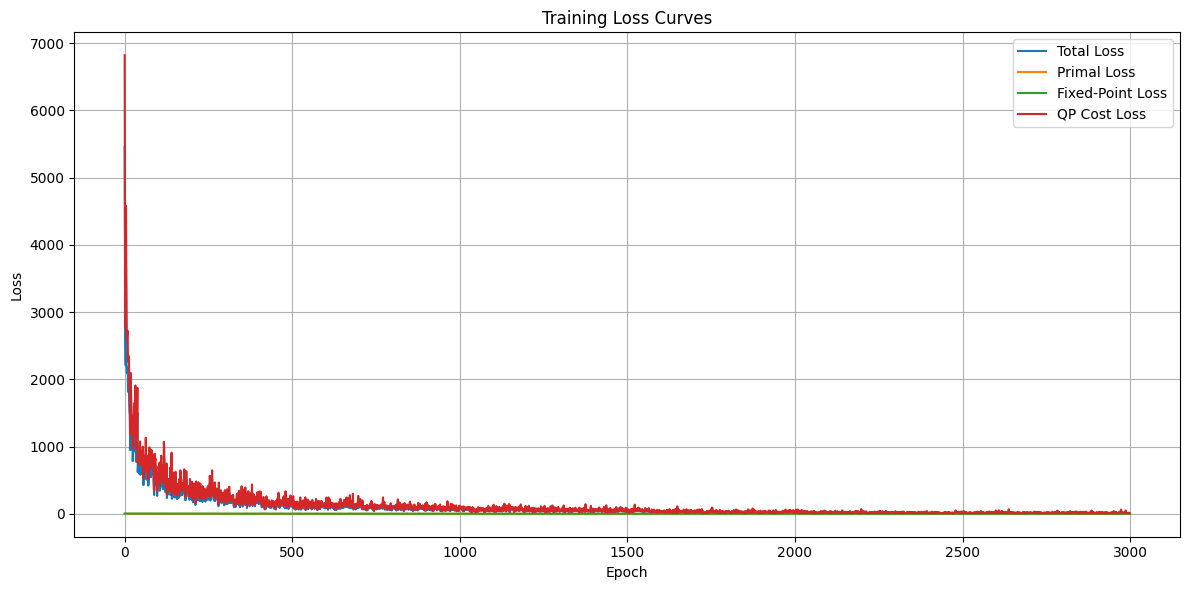

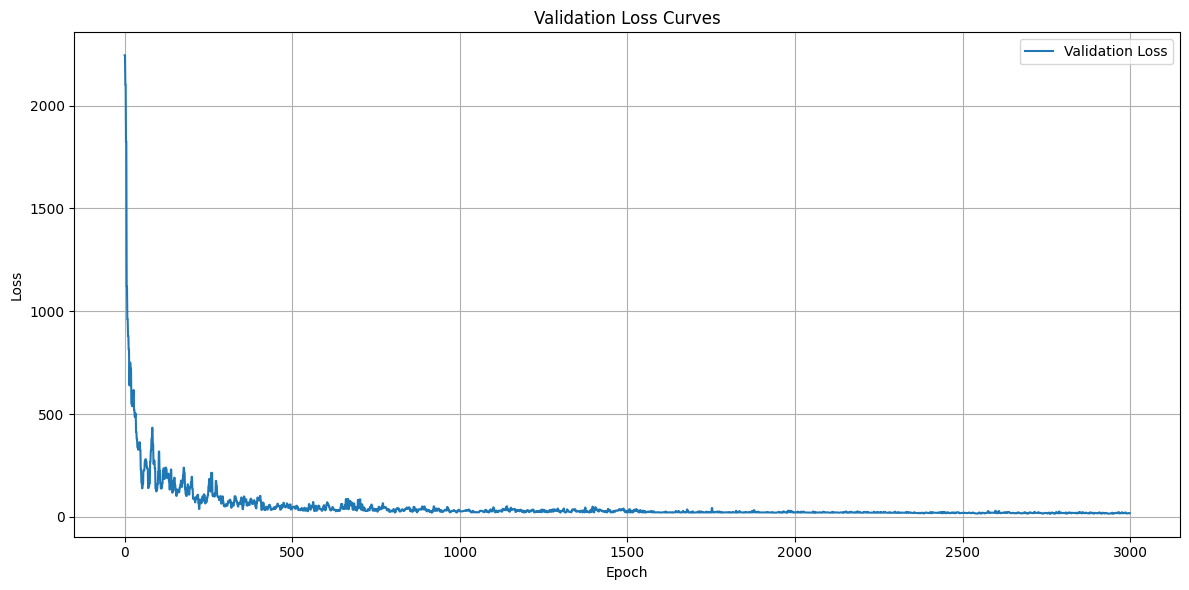

In [23]:
# Plot training losses

plt.figure(figsize=(12, 6))

plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_qp_cost_loss, label='QP Cost Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
avg_fixed_point_loss = np.asarray(avg_fixed_point_loss)
avg_qp_cost_loss = np.asarray(avg_qp_cost_loss)

print("Training_loss_start", avg_train_loss[0])
print("Validation_loss_start", avg_val_loss[0])
print("Fixed_Point_loss_start", avg_fixed_point_loss[0])
print("QP_loss_start", avg_qp_cost_loss[0])

print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])
print("Fixed_Point_loss_end", avg_fixed_point_loss[-1])
print("QP_loss_end", avg_qp_cost_loss[-1])

Training_loss_start 5459.323
Validation_loss_start 2245.4583
Fixed_Point_loss_start 3.8039234
QP_loss_start 6819.3994
Training_loss_end 6.0677567
Validation_loss_end 17.231607
Fixed_Point_loss_end 0.24340658
QP_loss_end 7.280437
